<a href="https://colab.research.google.com/github/jm5159/E4511-2021-Mao/blob/master/EDA_With_Harmonization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Exploratory data analysis

In this notebook we will analyze assay measurements and molecules for datasets from Chembl, DTC and Excape.
1. ***COPY*** this notebook into your own google drive. Work and edit from that one
2. For homework, you will work on this entire notebook for your own targets. Download your target related data from the following databases:
  - https://www.ebi.ac.uk/chembl/
  - https://drugtargetcommons.fimm.fi/
  - https://solr.ideaconsult.net/search/excape/


## Mount your drive where you have the Columbia_E4511 **folder**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#**Install packages** 

In [2]:
%tensorflow_version 1.x

# get the Anaconda file 
! wget -c https://repo.anaconda.com/archive/Anaconda3-2019.10-Linux-x86_64.sh
! chmod +x Anaconda3-2019.10-Linux-x86_64.sh
! bash ./Anaconda3-2019.10-Linux-x86_64.sh -b -f -p /usr/local

! time conda install -y -c deepchem -c rdkit -c conda-forge -c omnia deepchem-gpu=2.3.0

import sys
sys.path.append('/usr/local/lib/python3.7/site-packages/')
import deepchem as dc

# install mordred, bravado and molvs
! time conda install -c conda-forge -y mordred bravado molvs

# get the Install AMPL_GPU_test.sh
!wget https://raw.githubusercontent.com/ravichas/AMPL-Tutorial/master/config/install_AMPL_GPU_test.sh

# run the script to install AMPL
! chmod u+x install_AMPL_GPU_test.sh
! ./install_AMPL_GPU_test.sh

TensorFlow 1.x selected.
--2021-03-25 18:03:50--  https://repo.anaconda.com/archive/Anaconda3-2019.10-Linux-x86_64.sh
Resolving repo.anaconda.com (repo.anaconda.com)... 104.16.130.3, 104.16.131.3, 2606:4700::6810:8303, ...
Connecting to repo.anaconda.com (repo.anaconda.com)|104.16.130.3|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 530308481 (506M) [application/x-sh]
Saving to: ‘Anaconda3-2019.10-Linux-x86_64.sh’

Anaconda3-2019.10-L 100%[===================>] 505.74M   193MB/s    in 2.6s    

2021-03-25 18:03:53 (193 MB/s) - ‘Anaconda3-2019.10-Linux-x86_64.sh’ saved [530308481/530308481]

PREFIX=/usr/local
Unpacking payload ...
Solving environment: \ | / - \ | / - \ | / - \ | done

## Package Plan ##

  environment location: /usr/local

  added / updated specs:
    - _ipyw_jlab_nb_ext_conf==0.1.0=py37_0
    - _libgcc_mutex==0.1=main
    - alabaster==0.7.12=py37_0
    - anaconda-client==1.7.2=py37_0
    - anaconda-navigator==1.9.7

/usr/local/lib/python3.7/dist-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

Solving environment: - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ done

## Package Plan ##

  environment location: /usr/local

  added / updated specs:
    - bravado
    - molvs
    - mordred


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    bravado-11.0.3             |     pyhd8ed1ab_0          31 KB  conda-forge
    bravado-core-5.17.0        |     pyh9f0ad1d_0          48 KB  conda-forge
  

# Load Libraries

In [3]:
# We temporarily disable warnings for demonstration.
# FutureWarnings and DeprecationWarnings are present from some of the AMPL 
# dependency modules.
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
# manipulate data
import pandas as pd

import json
import requests
import io
import seaborn as sns
import matplotlib.pyplot as plt

import matplotlib_venn as mpv
from scipy.stats import pearsonr

# set up visualization parameters
sns.set_context("paper")
sns.set_style("whitegrid")
sns.set_palette("Set2")
pal = sns.color_palette()
plt.rcParams['figure.figsize'] = [10,10]

pd.set_option('display.max_columns',(90))
pd.set_option('display.max_rows',(20))

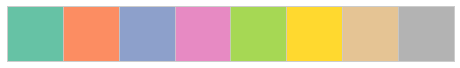

In [4]:
sns.palplot(pal)

In [5]:
# Import AMPL libraries
# 
import atomsci.ddm.utils.data_curation_functions as dcf
import atomsci.ddm.utils.curate_data as curate_data
import atomsci.ddm.pipeline.diversity_plots as dp
import atomsci.ddm.pipeline.chem_diversity as cd
# Additional python libraries
import pandas as pd
import numpy as np
import getpass, os

# Download/Load data

In [6]:
! wget https://raw.githubusercontent.com/jm5159/E4511-2021-Mao/master/Dataset/chembl.tsv
! wget https://raw.githubusercontent.com/jm5159/E4511-2021-Mao/master/Dataset/DTC_CYP3A4.csv
! wget https://raw.githubusercontent.com/jm5159/E4511-2021-Mao/master/Dataset/CYP3A4_excape.tsv

--2021-03-25 18:10:40--  https://raw.githubusercontent.com/jm5159/E4511-2021-Mao/master/Dataset/chembl.tsv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5727350 (5.5M) [text/plain]
Saving to: ‘chembl.tsv’

chembl.tsv          100%[===================>]   5.46M  --.-KB/s    in 0.1s    

2021-03-25 18:10:41 (39.3 MB/s) - ‘chembl.tsv’ saved [5727350/5727350]

--2021-03-25 18:10:41--  https://raw.githubusercontent.com/jm5159/E4511-2021-Mao/master/Dataset/DTC_CYP3A4.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 16910891 (16M) [

# Explore and examine **data**

In [7]:
dtc = pd.read_csv("DTC_CYP3A4.csv")
excape = pd.read_table("CYP3A4_excape.tsv")
chembl = pd.read_table('chembl.tsv')

In [8]:
dtc.iloc[1:3,1:10]

standard_inchi_key compound_name synonym target_id  \
1  AAALVYBICLMAMA-UHFFFAOYSA-N          DAPH     NaN    P08684   
2  AAAOTGDHZDZLFN-UHFFFAOYSA-N           NaN     NaN    P08684   

      target_pref_name gene_names wildtype_or_mutant mutation_info   pubmed_id  
1  CYTOCHROME P450 3A4     CYP3A4                NaN           NaN         NaN  
2  CYTOCHROME P450 3A4     CYP3A4                NaN           NaN  21657270.0

In [9]:
excape.iloc[1:3, 1:15]

Original_Entry_ID  Entrez_ID Activity_Flag  pXC50       DB  \
1              8783       1576             N    NaN  pubchem   
2              8197       1576             N    NaN  pubchem   

   Original_Assay_ID  Tax_ID Gene_Symbol Ortholog_Group              SMILES  
1                885    9606      CYP3A4            un4  ClCCOP(OCCCl)OCCCl  
2                885    9606      CYP3A4            un4     N(CCNCCN)CCNCCN

In [10]:
chembl.iloc[1:3, 1:10]

Molecule Name  Molecule Max Phase Molecular Weight #RO5 Violations AlogP  \
1           NaN                   0           528.54               1  3.67   
2           NaN                   0           496.52               0  2.93   

  Compound Key                                             Smiles  \
1       29-rac  CCc1nc(N)nc(N)c1-c1ccc2c(c1)N(CCNC(C)=O)C(=O)C...   
2       26-rac  CCc1nc(N)nc(N)c1-c1ccc2c(c1)N(CCNC(C)=O)C(=O)C...   

  Standard Type Standard Relation  
1          IC50               '='  
2          IC50               '='

## **Examine and clean data** 
- What molecular (and other) identifiers exist for compounds from each database?
- What assay response types are there in each file?
- Think about how we might combine these data sources together

In [11]:
# get rid of spaces
chembl.columns = chembl.columns.str.replace(' ','_') 
dtc.columns = dtc.columns.str.replace(' ','_') 
excape.columns = excape.columns.str.replace(' ','_') 


print(chembl.shape)
print(dtc.shape)
print(excape.shape)

(9902, 41)
(47075, 33)
(19324, 11)


### Questions to ask while exploring data

- what molecular (and other) identifiers exist for compounds from each database?
- what assay response types are there in each file?
- think about how we might combine these data sources together

## ChEMBL: Explore `dataset`

In [12]:
chembl.head()

Molecule_ChEMBL_ID Molecule_Name  Molecule_Max_Phase Molecular_Weight  \
0       CHEMBL240954           NaN                   0           516.46   
1       CHEMBL393363           NaN                   0           528.54   
2       CHEMBL398584           NaN                   0           496.52   
3       CHEMBL514681           NaN                   0           406.91   
4       CHEMBL452423           NaN                   0           379.85   

  #RO5_Violations AlogP Compound_Key  \
0               2  1.92            9   
1               1  3.67       29-rac   
2               0  2.93       26-rac   
3               0  4.29            8   
4               0  3.37           14   

                                              Smiles Standard_Type  \
0  CC(=O)O[C@H]1[C@H](C)O[C@@H](Oc2c(-c3ccc(O)cc3...          IC50   
1  CCc1nc(N)nc(N)c1-c1ccc2c(c1)N(CCNC(C)=O)C(=O)C...          IC50   
2  CCc1nc(N)nc(N)c1-c1ccc2c(c1)N(CCNC(C)=O)C(=O)C...          IC50   
3     O=C(CCc1ccccc1)NCC(=O)NC(c1ccccc1)c1ccc(Cl)cc1          IC50   
4       O=C(CNC(=O)c1ccncc1)NC(c1ccccc1)c1ccc(Cl)cc1          IC50   

  Standard_Relation  Standard_Value Standard_Units  pChEMBL_Value  \
0               '='         20600.0             nM           4.69   
1               '='           120.0             nM           6.92   
2               '='           860.0             nM           6.07   
3               '>'         50000.0             nM            NaN   
4               '>'         50000.0             nM            NaN   

  Data_Validity_Comment Comment    Uo_Units  Ligand_Efficiency_BEI  \
0                   NaN     NaN  UO_0000065                    NaN   
1                   NaN     NaN  UO_0000065                    NaN   
2                   NaN     NaN  UO_0000065                    NaN   
3                   NaN     NaN  UO_0000065                    NaN   
4                   NaN     NaN  UO_0000065                    NaN   

   Ligand_Efficiency_LE  Ligand_Efficiency_LLE  Ligand_Efficiency_SEI  \
0                   NaN                    NaN                    NaN   
1                   NaN                    NaN                    NaN   
2                   NaN                    NaN                    NaN   
3                   NaN                    NaN                    NaN   
4                   NaN                    NaN                    NaN   

   Potential_Duplicate Assay_ChEMBL_ID  \
0                False   CHEMBL1000805   
1                False    CHEMBL898579   
2                False    CHEMBL898579   
3                False    CHEMBL995045   
4                False    CHEMBL995045   

                                 Assay_Description Assay_Type BAO_Format_ID  \
0  Inhibition of human CYP3A4 by radiometric assay          A   BAO_0000357   
1                             Inhibition of CYP3A4          A   BAO_0000357   
2                             Inhibition of CYP3A4          A   BAO_0000357   
3                             Inhibition of CYP3A4          A   BAO_0000357   
4                             Inhibition of CYP3A4          A   BAO_0000357   

               BAO_Label Assay_Organism Assay_Tissue_ChEMBL_ID  \
0  single protein format   Homo sapiens                   None   
1  single protein format           None                   None   
2  single protein format           None                   None   
3  single protein format           None                   None   
4  single protein format           None                   None   

  Assay_Tissue_Name Assay_Cell_Type Assay_Subcellular_Fraction  \
0              None            None                       None   
1              None            None                       None   
2              None            None                       None   
3              None            None                       None   
4              None            None                       None   

  Target_ChEMBL_ID          Target_Name Target_Organism     Target_Type  \
0        CHEMBL34

In [13]:
chembl.Standard_Type.value_counts()

IC50    9902
Name: Standard_Type, dtype: int64

## DTC: Explore dataset
Explore the loaded DTC and Excape dataframes, and answer the following questions:

- Number of data points in each file?
- Molecular identifiers from each file?
- Data types from each file?
- Data units in each file?
- What is the formula to translate IC50 to pIC50?
- What other information might be useful?

In [14]:
dtc.head(3)

compound_id           standard_inchi_key compound_name synonym target_id  \
0   CHEMBL268868  AAALVYBICLMAMA-UHFFFAOYSA-N          DAPH     NaN    P08684   
1   CHEMBL268868  AAALVYBICLMAMA-UHFFFAOYSA-N          DAPH     NaN    P08684   
2  CHEMBL1800663  AAAOTGDHZDZLFN-UHFFFAOYSA-N           NaN     NaN    P08684   

      target_pref_name gene_names wildtype_or_mutant mutation_info  \
0  CYTOCHROME P450 3A4     CYP3A4                NaN           NaN   
1  CYTOCHROME P450 3A4     CYP3A4                NaN           NaN   
2  CYTOCHROME P450 3A4     CYP3A4                NaN           NaN   

    pubmed_id standard_type standard_relation  standard_value standard_units  \
0         NaN       POTENCY                 =          1584.9             NM   
1         NaN       POTENCY                 =          1584.9             NM   
2  21657270.0    INHIBITION                 =            64.0              %   

  activity_comment ep_action_mode assay_format assaytype assay_subtype  \
0           Active            NaN          NaN       NaN           NaN   
1       Not Active            NaN          NaN       NaN           NaN   
2              NaN            NaN          NaN       NaN           NaN   

  inhibitor_type detection_tech assay_cell_line compound_concentration_value  \
0            NaN            NaN             NaN                          NaN   
1            NaN            NaN             NaN                          NaN   
2            NaN            NaN             NaN                          NaN   

  compound_concentration_value_unit substrate_type substrate_relation  \
0                               NaN            NaN                NaN   
1                               NaN            NaN                NaN   
2                               NaN            NaN                NaN   

  substrate_value substrate_units  \
0             NaN             NaN   
1             NaN             NaN   
2             NaN             NaN   

                                   assay_description  \
0  PUBCHEM_BIOASSAY: qHTS Assay for Inhibitors an...   
1  PUBCHEM_BIOASSAY: qHTS Assay for Activators of...   
2  Inhibition of human CYP3A4 assessed as convers...   

                                               title        journal  \
0                          PUBCHEM BIOASSAY DATA SET            NaN   
1                          PUBCHEM BIOASSAY DATA SET            NaN   
2  Discovery of 1-{4-[1-(2,6-difluorobenzyl)-5-[(...  J. Med. Chem.   

      doc_type annotation_comments  
0      DATASET                 NaN  
1      DATASET                 NaN  
2  PUBLICATION                 NaN

In [15]:
dtc['standard_type'].value_counts()

AC50          16833
POTENCY       13587
IC50           8977
INHIBITION     3145
ACTIVITY       1232
              ...  
LOG IC50          1
Imax              1
Kinact            1
PB                1
KDISS             1
Name: standard_type, Length: 58, dtype: int64

#### Assay data exploration

In [16]:
len(chembl.Assay_Description.unique()) 

761

Assay data responses questions
- What type of variable are the data responses?
- What kind of ML model would you build to predict this data?
- What kind of visualizations & analysis can you use to understand more about the data?

In [17]:
chembl.head(3)

Molecule_ChEMBL_ID Molecule_Name  Molecule_Max_Phase Molecular_Weight  \
0       CHEMBL240954           NaN                   0           516.46   
1       CHEMBL393363           NaN                   0           528.54   
2       CHEMBL398584           NaN                   0           496.52   

  #RO5_Violations AlogP Compound_Key  \
0               2  1.92            9   
1               1  3.67       29-rac   
2               0  2.93       26-rac   

                                              Smiles Standard_Type  \
0  CC(=O)O[C@H]1[C@H](C)O[C@@H](Oc2c(-c3ccc(O)cc3...          IC50   
1  CCc1nc(N)nc(N)c1-c1ccc2c(c1)N(CCNC(C)=O)C(=O)C...          IC50   
2  CCc1nc(N)nc(N)c1-c1ccc2c(c1)N(CCNC(C)=O)C(=O)C...          IC50   

  Standard_Relation  Standard_Value Standard_Units  pChEMBL_Value  \
0               '='         20600.0             nM           4.69   
1               '='           120.0             nM           6.92   
2               '='           860.0             nM           6.07   

  Data_Validity_Comment Comment    Uo_Units  Ligand_Efficiency_BEI  \
0                   NaN     NaN  UO_0000065                    NaN   
1                   NaN     NaN  UO_0000065                    NaN   
2                   NaN     NaN  UO_0000065                    NaN   

   Ligand_Efficiency_LE  Ligand_Efficiency_LLE  Ligand_Efficiency_SEI  \
0                   NaN                    NaN                    NaN   
1                   NaN                    NaN                    NaN   
2                   NaN                    NaN                    NaN   

   Potential_Duplicate Assay_ChEMBL_ID  \
0                False   CHEMBL1000805   
1                False    CHEMBL898579   
2                False    CHEMBL898579   

                                 Assay_Description Assay_Type BAO_Format_ID  \
0  Inhibition of human CYP3A4 by radiometric assay          A   BAO_0000357   
1                             Inhibition of CYP3A4          A   BAO_0000357   
2                             Inhibition of CYP3A4          A   BAO_0000357   

               BAO_Label Assay_Organism Assay_Tissue_ChEMBL_ID  \
0  single protein format   Homo sapiens                   None   
1  single protein format           None                   None   
2  single protein format           None                   None   

  Assay_Tissue_Name Assay_Cell_Type Assay_Subcellular_Fraction  \
0              None            None                       None   
1              None            None                       None   
2              None            None                       None   

  Target_ChEMBL_ID          Target_Name Target_Organism     Target_Type  \
0        CHEMBL340  Cytochrome P450 3A4    Homo sapiens  SINGLE PROTEIN   
1        CHEMBL340  Cytochrome P450 3A4    Homo sapiens  SINGLE PROTEIN   
2        CHEMBL340  Cytochrome P450 3A4    Homo sapiens  SINGLE PROTEIN   

  Document_ChEMBL_ID  Source_ID     Source_Description    Document_Journal  \
0      CHEMBL1151241          1  Scientific Literature       J. Nat. Prod.   
1      CHEMBL1149625          1  Scientific Literature  Bioorg. Med. Chem.   
2      CHEMBL1149625          1  Scientific Literature  Bioorg. Med. Chem.   

   Document_Year Cell_ChEMBL_ID  
0         2004.0           None  
1         2007.0           None  
2         2007.0           None

In [18]:
chembl.Standard_Units.unique()

array(['nM', nan, 'ug.mL-1', 'min'], dtype=object)

## Excape-DB: Explore dataset

In [19]:
excape.columns

Index(['Ambit_InchiKey', 'Original_Entry_ID', 'Entrez_ID', 'Activity_Flag',
       'pXC50', 'DB', 'Original_Assay_ID', 'Tax_ID', 'Gene_Symbol',
       'Ortholog_Group', 'SMILES'],
      dtype='object')

In [20]:
excape.Activity_Flag.unique()

array(['N', 'A'], dtype=object)

In [21]:
excape['DB']

0         pubchem
1         pubchem
2         pubchem
3         pubchem
4         pubchem
           ...   
19319    chembl20
19320     pubchem
19321     pubchem
19322     pubchem
19323     pubchem
Name: DB, Length: 19324, dtype: object

In [22]:
excape.shape

(19324, 11)

## **ChEMBL: Curation step** 
Change units to be the same for all responses

In [23]:
# change uM to nM units so they're all the same
chembl['Standard_Value_nM'] = np.where(chembl.Standard_Units == 'uM',
                                           chembl.Standard_Value * 1000,
                                           chembl.Standard_Value)

#### ChEMBL EDA
Summarize, describe, plot data for analysis

In [24]:
# summary statistics
chembl.describe()

Molecule_Max_Phase  Standard_Value  pChEMBL_Value  \
count         9902.000000    8.629000e+03    4853.000000   
mean             0.436477    8.425227e+04       5.475024   
std              1.214395    1.800720e+06       0.899686   
min              0.000000    0.000000e+00       4.000000   
25%              0.000000    3.000000e+03       4.820000   
50%              0.000000    1.000000e+04       5.300000   
75%              0.000000    2.750000e+04       5.960000   
max              4.000000    7.762471e+07      10.300000   

       Ligand_Efficiency_BEI  Ligand_Efficiency_LE  Ligand_Efficiency_LLE  \
count             586.000000            586.000000             586.000000   
mean               11.300256              0.213481               1.272799   
std                 5.845508              0.109255               1.340193   
min                 4.920000              0.090000              -3.520000   
25%                 7.400000              0.140000               0.580000   
50%                10.030000              0.190000               1.440000   
75%                12.760000              0.247500               2.140000   
max                55.910000              1.030000               5.080000   

       Ligand_Efficiency_SEI    Source_ID  Document_Year  Standard_Value_nM  
count             586.000000  9902.000000     8868.00000       8.629000e+03  
mean                6.944829     6.344476     2012.20106       8.425227e+04  
std                 6.052495    11.520291        3.73373       1.800720e+06  
min                 1.980000     1.000000     1992.00000       0.000000e+00  
25%                 4.040000     1.000000     2010.00000       3.000000e+03  
50%                 5.220000     1.000000     2012.00000       1.000000e+04  
75%                 6.992500     1.000000     2015.00000       2.750000e+04  
max                57.320000    38.000000     2018.00000       7.762471e+07


Why do some columns seem numeric but not give mean, SD? Examine chembl csv file - answer is some 'None' entries

In [25]:
chembl=chembl.replace('None',np.nan)

In [26]:
# even after removing None you have to recast the column as numeric
numeric_cols=['Molecule_Max_Phase',
       'Molecular_Weight', '#RO5_Violations', 'AlogP', 'Standard_Value_nM',
       'pChEMBL_Value', 'Ligand_Efficiency_BEI', 'Ligand_Efficiency_LE',
       'Ligand_Efficiency_LLE', 'Ligand_Efficiency_SEI']
for col in numeric_cols:
  chembl[col]=chembl[col].astype(float)

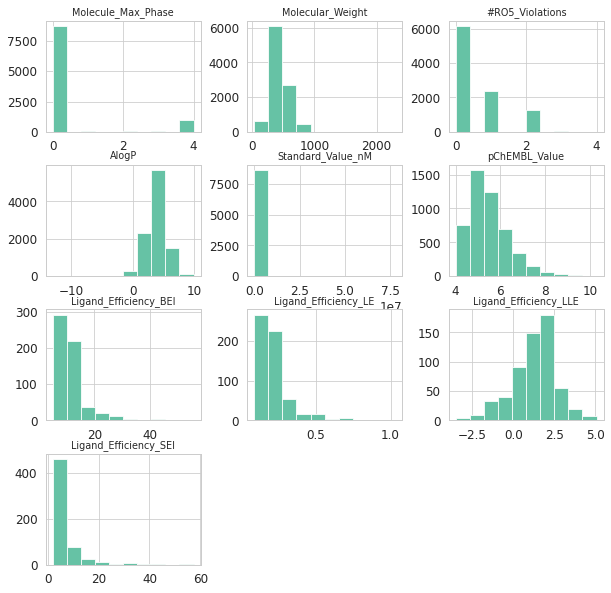

In [27]:
chembl[numeric_cols].hist(figsize=(10,10));

- **Note that pChembl value is better normalized than standard value**
- **Recall that there are lots of different activity types/assays represented in the value columns. Let's split those up:**

Standard_Type          IC50
count          7.090000e+03
mean           6.774203e+04
std            1.121467e+06
min            0.000000e+00
25%            3.300000e+03
50%            1.000000e+04
75%            2.900000e+04
max            3.885116e+07

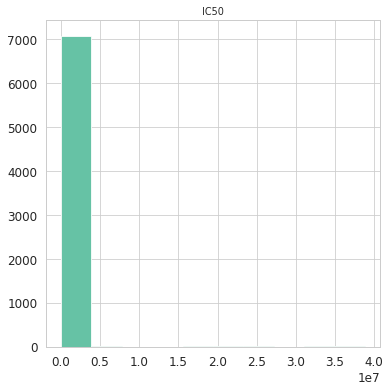

In [28]:
# examine standard values and pChembl values PER standard type
chembl_types=chembl.pivot_table(index = 'Molecule_ChEMBL_ID', columns = 'Standard_Type', values='Standard_Value_nM', aggfunc='mean')
display(chembl_types.describe())
chembl_types.hist(figsize=(6,6));

 What do you notice about the standard values?

Standard_Type         IC50
count          4054.000000
mean              5.467381
std               0.878229
min               4.000000
25%               4.840000
50%               5.300000
75%               5.920000
max              10.300000

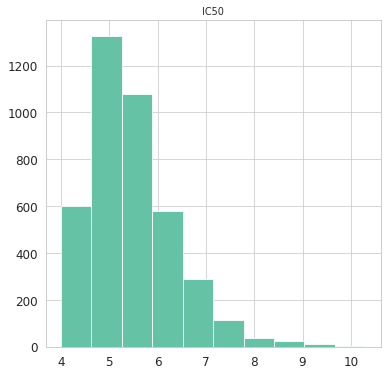

In [29]:
chembl_types=chembl.pivot_table(index = 'Molecule_ChEMBL_ID', columns = 'Standard_Type', values='pChEMBL_Value', aggfunc='mean')
display(chembl_types.describe())
chembl_types.hist(figsize=(6,6));

- **What do you notice about the pChEMBL values?**

## DTC: Curation Step
- Add pValue column from raw measurements if it doesn't exist

In [30]:
dtc.iloc[0:3, 0:5]

compound_id           standard_inchi_key compound_name synonym target_id
0   CHEMBL268868  AAALVYBICLMAMA-UHFFFAOYSA-N          DAPH     NaN    P08684
1   CHEMBL268868  AAALVYBICLMAMA-UHFFFAOYSA-N          DAPH     NaN    P08684
2  CHEMBL1800663  AAAOTGDHZDZLFN-UHFFFAOYSA-N           NaN     NaN    P08684

## DTC EDA

In [31]:
dtc=dtc.replace('None', np.nan)


In [32]:
dtc.head(3)

compound_id           standard_inchi_key compound_name synonym target_id  \
0   CHEMBL268868  AAALVYBICLMAMA-UHFFFAOYSA-N          DAPH     NaN    P08684   
1   CHEMBL268868  AAALVYBICLMAMA-UHFFFAOYSA-N          DAPH     NaN    P08684   
2  CHEMBL1800663  AAAOTGDHZDZLFN-UHFFFAOYSA-N           NaN     NaN    P08684   

      target_pref_name gene_names wildtype_or_mutant mutation_info  \
0  CYTOCHROME P450 3A4     CYP3A4                NaN           NaN   
1  CYTOCHROME P450 3A4     CYP3A4                NaN           NaN   
2  CYTOCHROME P450 3A4     CYP3A4                NaN           NaN   

    pubmed_id standard_type standard_relation  standard_value standard_units  \
0         NaN       POTENCY                 =          1584.9             NM   
1         NaN       POTENCY                 =          1584.9             NM   
2  21657270.0    INHIBITION                 =            64.0              %   

  activity_comment ep_action_mode assay_format assaytype assay_subtype  \
0           Active            NaN          NaN       NaN           NaN   
1       Not Active            NaN          NaN       NaN           NaN   
2              NaN            NaN          NaN       NaN           NaN   

  inhibitor_type detection_tech assay_cell_line compound_concentration_value  \
0            NaN            NaN             NaN                          NaN   
1            NaN            NaN             NaN                          NaN   
2            NaN            NaN             NaN                          NaN   

  compound_concentration_value_unit substrate_type substrate_relation  \
0                               NaN            NaN                NaN   
1                               NaN            NaN                NaN   
2                               NaN            NaN                NaN   

  substrate_value substrate_units  \
0             NaN             NaN   
1             NaN             NaN   
2             NaN             NaN   

                                   assay_description  \
0  PUBCHEM_BIOASSAY: qHTS Assay for Inhibitors an...   
1  PUBCHEM_BIOASSAY: qHTS Assay for Activators of...   
2  Inhibition of human CYP3A4 assessed as convers...   

                                               title        journal  \
0                          PUBCHEM BIOASSAY DATA SET            NaN   
1                          PUBCHEM BIOASSAY DATA SET            NaN   
2  Discovery of 1-{4-[1-(2,6-difluorobenzyl)-5-[(...  J. Med. Chem.   

      doc_type annotation_comments  
0      DATASET                 NaN  
1      DATASET                 NaN  
2  PUBLICATION                 NaN

In [33]:
dtc.standard_units.unique() #already all nM

array(['NM', '%', nan, '/MIN', 'UM', 'MIN-1', '/UM/MIN', 'MM', '/MIN/MM',
       'ML.MIN-1.G-1', 'PMOL/MIN', 'NG/ML', 'L/MIN/UMOL', 'UL/MIN', 'HR',
       'MIN', '/MIN/MICROM', '/MIN/NM', '/S', 'DEGREES C', 'UL/MIN/NMOL',
       'PMOL/MIN/PMOL', 'UG.ML-1', 'ML/MIN/UMOL', "10'-4/MIN",
       'UL/MIN/PMOL', 'ML/MIN/NMOL', 'PMOL/HR', 'PMOL/MG.MIN',
       'UL/MIN.MG', 'NMOL/MIN', '/NM.MIN', 'MOL/MIN', 'NMOL/MIN/MG',
       "10'3ML/MIN", 'ML/MIN/MG', 'UL.MIN.NMOL-1', 'PMOL.MIN.MG-1',
       'UL/MG/MIN', 'ML/MIN/UL'], dtype=object)

In [34]:
dtc.standard_type.unique()

array(['POTENCY', 'INHIBITION', 'IC50', 'AC50', 'ACTIVITY', 'TDI', 'KI',
       'KINACT', 'INH', 'EC50', 'RATIO', 'RATIO IC50', 'STABILITY', 'CL',
       'KCAT', 'KM', 'MAX ACTIVATION', 'LOG 1/KM',
       'MECHANISM BASED INHIBITION', 'EFFICACY', 'DRUG METABOLISM',
       'RATE OF OXIDATION', 'FC', 'Inhibition', 'IC90',
       'COMPOUND RECOVERY', 'VMAX', 'STABILTY', 'PARTITION RATIO',
       'PIC50', 'KD', 'EMAX', 'T1/2', 'RETENTION_TIME', 'K',
       'INHIBITORY INDEX', 'IC20', 'KS', 'TM', 'CL FREE', 'FM',
       'Stabilty', 'PB', 'CONTROL OF P-450 MARKER', 'Delta Tm', 'Kd',
       'VMAX(APP)', 'VMAX/KM', 'CMAX', 'LOG IC50', 'Activity', 'KDISS',
       'IC5', 'Imax', 'Ratio', 'Ki', 'Kinact', 'max activation'],
      dtype=object)

In [35]:
dtc[dtc.standard_units=='NM'].standard_type.unique()

array(['POTENCY', 'IC50', 'AC50', 'KI', 'EC50', 'ACTIVITY', 'INH', 'KM',
       'IC90', 'DRUG METABOLISM', 'KD', 'IC20', 'KS', 'INHIBITION', 'Kd',
       'KINACT', 'LOG IC50', 'IC5', 'Ki', 'Activity'], dtype=object)

Curation step: create pValues from normal values

In [36]:
# add pX column
dtc['pDTC_Value'] = np.where(dtc.standard_units == 'NM',
                             -np.log10(dtc.standard_value/1000000000 ),
                             dtc.standard_value)

In [37]:
dtc.describe()

pubmed_id  standard_value    pDTC_Value
count  1.340800e+04    3.505600e+04  3.505600e+04
mean   2.124769e+07    2.096827e+05           inf
std    4.345972e+06    1.313237e+07           NaN
min   -1.000000e+00   -3.500000e+01 -3.500000e+01
25%    1.955243e+07    1.995260e+03  4.800000e+00
50%    2.200963e+07    6.700000e+03  5.099999e+00
75%    2.382995e+07    1.584890e+04  5.602060e+00
max    2.929777e+07    1.000000e+09           inf

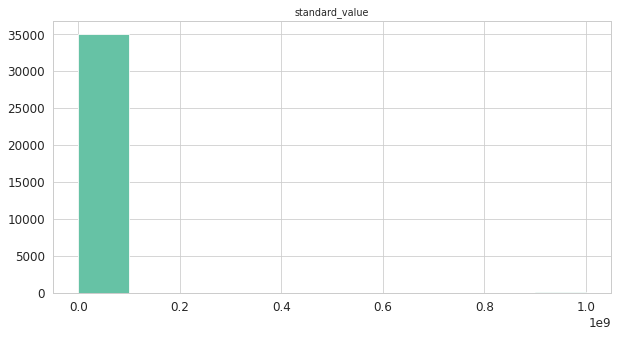

In [38]:
numeric_cols=['standard_value']
dtc[numeric_cols].hist(figsize=(10,5));

standard_type          AC50      ACTIVITY      Activity           CL  CL FREE  \
count          8.653000e+03  4.860000e+02     18.000000    32.000000      1.0   
mean           7.043361e+05  3.895242e+04   4303.355556    35.931469     61.0   
std            2.632461e+07  2.091780e+05   9746.035274   178.464418      NaN   
min            1.260000e+00  0.000000e+00     25.000000     0.016000     61.0   
25%            3.162280e+03  3.000000e+01     73.175000     1.225000     61.0   
50%            8.912510e+03  9.100000e+01     87.150000     2.850000     61.0   
75%            1.584893e+04  2.200000e+03    104.775000     3.550000     61.0   
max            1.000000e+09  2.512000e+06  30000.000000  1013.100000     61.0   

standard_type  CMAX  COMPOUND RECOVERY  CONTROL OF P-450 MARKER  \
count          1.00          29.000000                      1.0   
mean           3.97           5.362586                     90.5   
std             NaN          13.958077                      NaN   
min            3.97           0.000000                     90.5   
25%            3.97           0.165000                     90.5   
50%            3.97           1.090000                     90.5   
75%            3.97           3.240000                     90.5   
max            3.97          72.500000                     90.5   

standard_type  DRUG METABOLISM  Delta Tm           EC50    EFFICACY  \
count                53.000000  7.000000      86.000000   48.000000   
mean                 91.865896 -0.471429   16583.279070  118.612500   
std                 363.041814  0.771825   21178.656793   79.913266   
min                   0.000000 -2.000000       2.000000   16.300000   
25%                   5.000000 -0.600000    3250.000000   52.850000   
50%                  18.200000 -0.200000   10000.000000   94.150000   
75%                  70.000000 -0.050000   15800.000000  169.800000   
max                2625.000000  0.200000  100000.000000  297.100000   

standard_type       EMAX         FC         FM          IC20           IC5  \
count           5.000000  23.000000   3.000000     13.000000      2.000000   
mean           27.100000   4.952409  23.111111   8653.846154  13015.000000   
std            32.427612   5.432405  38.876347  14759.607909  18363.563107   
min             0.000000   0.970000   0.333333    100.000000     30.000000   
25%             3.500000   2.050000   0.666667    600.000000   6522.500000   
50%             9.000000   2.500000   1.000000   2000.000000  13015.000000   
75%            51.000000   6.565000  34.500000   5000.000000  19507.500000   
max            72.000000  24.066250  68.000000  50000.000000  26000.000000   

standard_type          IC50           IC90            INH    INHIBITION  \
count          5.829000e+03       7.000000     356.000000   1744.000000   
mean           7.349833e+04   91742.857143   17885.061829     85.389522   
std            1.215805e+06   20179.020223   17054.212399   1394.922938   
min            0.000000e+00   46100.000000       0.011000    -34.000000   
25%            2.200000e+03   98050.000000    4800.000000     15.000000   
50%            1.000000e+04  100000.000000   13000.000000     33.000000   
75%            2.962500e+04  100000.000000   25000.000000     63.000000   
max            3.885116e+07  100000.000000  100000.000000  50000.000000   

standard_type  INHIBITORY INDEX  Imax  Inhibition          K       KCAT  \
count                  9.000000   1.0   57.000000  17.000000  24.000000   
mean                   0.795556  40.0   30.896228   3.351294  10.641612   
std                    0.155412   NaN   28.577950   5.085781  10.228254   
min                    0.390000  40.0  -28.700000   0.030000   0.009550   
25%                    0.800000  40.0    7.500000   0.500000   4.508333   
50%                    0.860000  40.0   25.000000   1.400000   8.816667   
75%                    0.870000  40.0   51.000000   4.000000  11.150000   
max                    0.880000  40.0   97.6850

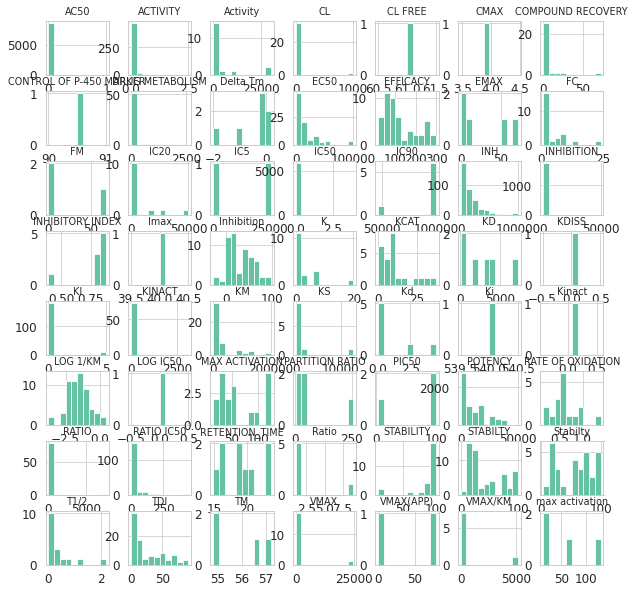

In [39]:
dtc_types=dtc.pivot_table(index = 'compound_id', columns = 'standard_type', values='standard_value', aggfunc='mean')
display(dtc_types.describe())
dtc_types.hist(figsize=(10,10));

In [40]:
excape=excape.replace('None', np.nan)
excape.head()

Ambit_InchiKey Original_Entry_ID  Entrez_ID Activity_Flag  \
0  YAYNEUUHHLGGAH-UHFFFAOYNA-N              8192       1576             N   
1  LUVCTYHBTXSAMX-UHFFFAOYNA-N              8783       1576             N   
2  FAGUFWYHJQFNRV-UHFFFAOYNA-N              8197       1576             N   
3  HQUQLFOMPYWACS-UHFFFAOYNA-N              8295       1576             N   
4  JVGPVVUTUMQJKL-UHFFFAOYNA-N              8196       1576             N   

   pXC50       DB  Original_Assay_ID  Tax_ID Gene_Symbol Ortholog_Group  \
0    NaN  pubchem                885    9606      CYP3A4            un4   
1    NaN  pubchem                885    9606      CYP3A4            un4   
2    NaN  pubchem                885    9606      CYP3A4            un4   
3    NaN  pubchem                885    9606      CYP3A4            un4   
4    NaN  pubchem                885    9606      CYP3A4            un4   

                   SMILES  
0          ClCCCCCCCCCCCC  
1      ClCCOP(OCCCl)OCCCl  
2         N(CCNCCN)CCNCCN  
3  ClCCOP(OCCCl)(OCCCl)=O  
4        S(CCOCCOCCCC)C#N

Entrez_ID         pXC50  Original_Assay_ID   Tax_ID
count    19324.0  14387.000000       1.932400e+04  19324.0
mean      1576.0      5.259378       5.141160e+05   9606.0
std          0.0      0.674275       3.458763e+05      0.0
min       1576.0      1.300000       8.840000e+02   9606.0
25%       1576.0      4.800000       8.850000e+02   9606.0
50%       1576.0      5.100000       7.378250e+05   9606.0
75%       1576.0      5.550000       7.378250e+05   9606.0
max       1576.0     10.660000       1.367425e+06   9606.0

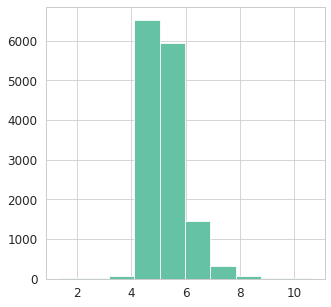

In [41]:
# excape only has one column we care about
display(excape.describe())
excape.pXC50.hist(figsize=(5,5));

# Compare pResponse values across ChEMBL, DTC and Excape-DB
- create a histogram or kde plot with legend showing distributions for all three datasets on the same plot

In [49]:
dtc[dtc['pDTC_Value']>=25000]

Empty DataFrame
Columns: [compound_id, standard_inchi_key, compound_name, synonym, target_id, target_pref_name, gene_names, wildtype_or_mutant, mutation_info, pubmed_id, standard_type, standard_relation, standard_value, standard_units, activity_comment, ep_action_mode, assay_format, assaytype, assay_subtype, inhibitor_type, detection_tech, assay_cell_line, compound_concentration_value, compound_concentration_value_unit, substrate_type, substrate_relation, substrate_value, substrate_units, assay_description, title, journal, doc_type, annotation_comments, pDTC_Value]
Index: []

In [48]:
dtc.drop([12336,42389,46720],inplace=True)
dtc.reset_index(drop=True, inplace=True)

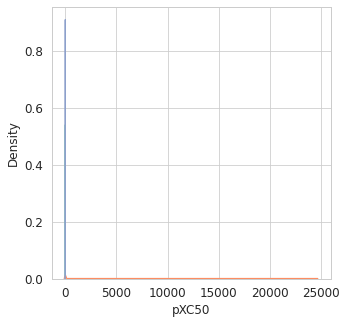

In [50]:
fig, ax = plt.subplots(1,1,figsize = (5,5))
sns.distplot(chembl.pChEMBL_Value, ax=ax)
sns.distplot(dtc.pDTC_Value, ax=ax)
sns.distplot(excape.pXC50, ax=ax);

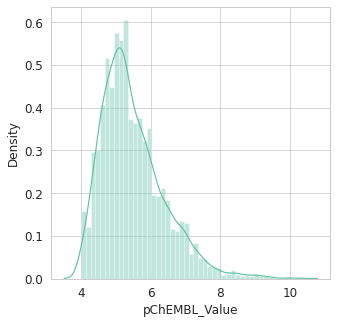

In [53]:
fig, ax = plt.subplots(1,1,figsize = (5,5))
sns.distplot(chembl.pChEMBL_Value, ax=ax)

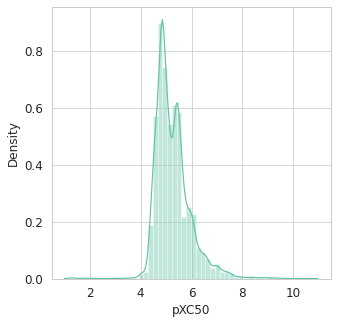

In [52]:
fig, ax = plt.subplots(1,1,figsize = (5,5))
sns.distplot(excape.pXC50, ax=ax);

In [54]:
dtc.to_csv('dtc_temp.csv',index=False)

# Analysis
- what value types you would model and why?
- how would you use this data for a classification model?
- do any of the three datasets include a column you could use for classification?

<p> I would model either pXC50 or pKI values. They are the most abundant in the dataset and commonly used for modeling. pKI is more normally distributed, but pXC50 values allow inclusion of excape data. 

According to some sources, these two datapoints can be combined in various ways, as well, but that's beyond the scope of this class.

I would choose a reasonable IC50 concentration to use as a threshold (perhaps 10uM, or consult with a scientist), and anything with an IC50 above that threshold is inactive (you need more drug to get activity) and IC50s below this threshold is active (you need less drug for activity, meaning the compound is MORE active per unit)

## EDA tips
- Make sure smiles strings exist since that's what AMPL uses
- Compare compounds in each dataset
- Featurize with ECFP fingerprints
- Examine diversity of compound set

# **Final Curation** **bold text** 

Get SMILES for DTC data from chemical identifiers
Since AMPL and other modeling pipelines use SMILES strings, we will use these as our primary data curation tool.
1. open DTC file in google sheets/excel or from the LHS folder menu, right-click on the "HTR3A_DTC.csv" file to download it to your computer and open the file with Excel. 
2. copy/paste the compound ID (ChEMBLXXXXXXX) column into pubchem ID exchange service: https://pubchem.ncbi.nlm.nih.gov/idexchange/idexchange.cgi  (use highlight and click on "Follow-link" option to open the link in your browser)
  - did you get the whole column??
  - Be sure to select the correct registry ID for the input id list
  - Select "Same CID" and SMILES as output

6. upload resulting text file into Columbia_E4511 folder

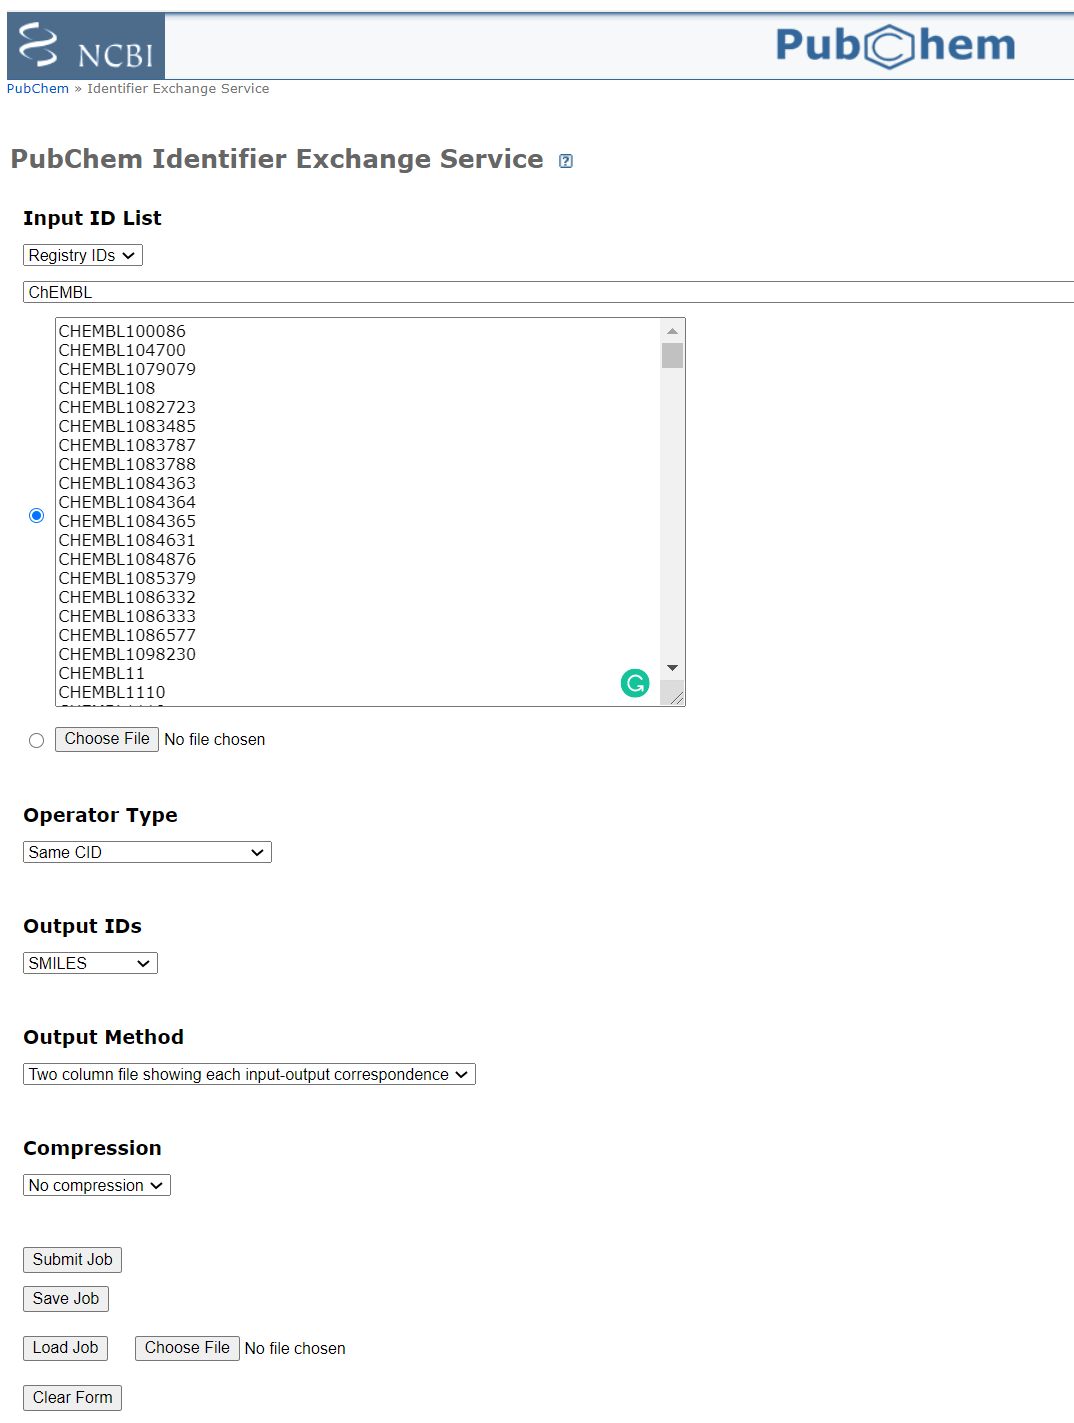

In [ ]:
from IPython.display import Image
Image("https://raw.githubusercontent.com/ravichas/AMPL-Tutorial/master/Img/PubChemCIDExchange.png", 
      width = 900, height = 900)

Note, the output from PubChem Identifier Exchange Service can be uploaded into the left hand window of COLAB by dragging and dropping the file. In my case the output file is, `3983437898785642818.txt`

In my case, I have saved the file in Google Drive and I am loading it in the following code chunk 

In [ ]:
# open file from pubchem ID exchange service
# dtc_smiles = pd.read_csv("/content/drive/MyDrive/Columbia_E4511/3983437898785642818.txt", sep="\t", header=None)

In [72]:
# the file is also available from my Github link 
!wget https://raw.githubusercontent.com/jm5159/E4511-2021-Mao/master/Dataset/1512737978895617998.txt
!wget https://raw.githubusercontent.com/jm5159/E4511-2021-Mao/master/Dataset/4214472887178066603.txt

--2021-03-25 18:36:58--  https://raw.githubusercontent.com/jm5159/E4511-2021-Mao/master/Dataset/1512737978895617998.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3397476 (3.2M) [text/plain]
Saving to: ‘1512737978895617998.txt.1’

1512737978895617998 100%[===================>]   3.24M  --.-KB/s    in 0.1s    

2021-03-25 18:36:59 (29.3 MB/s) - ‘1512737978895617998.txt.1’ saved [3397476/3397476]

--2021-03-25 18:36:59--  https://raw.githubusercontent.com/jm5159/E4511-2021-Mao/master/Dataset/4214472887178066603.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, 

In [58]:
# uncomment if you want to acess the files 
dtc_smiles = pd.read_csv("1512737978895617998.txt", sep='\t', header=None)
dtc_smiles.head(3)

0                                                  1
0   CHEMBL268868  C1=CC=C(C=C1)NC2=C(C=C3C(=C2)C(=O)NC3=O)NC4=CC...
1   CHEMBL268868  C1=CC=C(C=C1)NC2=C(C=C3C(=C2)C(=O)NC3=O)NC4=CC...
2  CHEMBL1800663  CN(CCC1=CC=CC=N1)CC2=C(SC3=C2C(=O)N(C(=O)N3CC4...

In [59]:
dtc_smiles=dtc_smiles.rename(columns = {0:'ChEMBL_ID',1:'SMILES'})
dtc_smiles.head()

ChEMBL_ID                                             SMILES
0   CHEMBL268868  C1=CC=C(C=C1)NC2=C(C=C3C(=C2)C(=O)NC3=O)NC4=CC...
1   CHEMBL268868  C1=CC=C(C=C1)NC2=C(C=C3C(=C2)C(=O)NC3=O)NC4=CC...
2  CHEMBL1800663  CN(CCC1=CC=CC=N1)CC2=C(SC3=C2C(=O)N(C(=O)N3CC4...
3  CHEMBL1232461  CCNC(=O)C[C@H]1C2=NN=C(N2C3=C(C=C(C=C3)OC)C(=N...
4  CHEMBL1232461  CCNC(=O)C[C@H]1C2=NN=C(N2C3=C(C=C(C=C3)OC)C(=N...

In [60]:
dtc[['compound_id']].head(3)

compound_id
0   CHEMBL268868
1   CHEMBL268868
2  CHEMBL1800663

#### Let us explore the `map(dict(zip()))` construct

In [61]:
# code from https://stackoverflow.com/questions/209840/how-do-i-convert-two-lists-into-a-dictionary;
# var names were modified
mykeys = ['a', 'b', 'c']
myvalues = [1, 2, 3]
mydict = dict(zip(mykeys, myvalues))
print(mydict) # {'a': 1, 'b': 2, 'c': 3}

{'a': 1, 'b': 2, 'c': 3}


In [62]:
import pandas as pd
s = pd.Series(['cat', 'dog', np.nan, 'rabbit'])
s.map({'cat': 'kitten', 'dog': 'puppy'})

0    kitten
1     puppy
2       NaN
3       NaN
dtype: object

In [63]:
# map chembl id to smiles using a dict
dtc['SMILES'] = dtc['compound_id'].map(dict(zip(dtc_smiles.ChEMBL_ID, dtc_smiles.SMILES)))

In [64]:
# what's missing?
print("No ChemblID in DTC:", len(dtc[dtc['compound_id'].isna()]))
print("No SMILES from ChemblID in DTC:", len(dtc[dtc.SMILES.isna()]))

No ChemblID in DTC: 337
No SMILES from ChemblID in DTC: 658


In [ ]:
# if you want to explore the data outside of COLAB
#  dtc.to_csv("test.csv")

#### For the missing Compound IDs, let us try to recover the SMILES from InChi Keys

In [66]:
miss=dtc[dtc.SMILES.isna()]['standard_inchi_key'].unique().tolist()

In [69]:
miss_df = pd.DataFrame(miss)

In [71]:
miss_df.to_csv('miss.csv',index=False)

The file 12345.txt is the output from NCBI ID Exchange using the above 29 InChi keys as input

In [ ]:
dtc.head(2)

compound_id           standard_inchi_key compound_name synonym target_id  \
0  CHEMBL268868  AAALVYBICLMAMA-UHFFFAOYSA-N          DAPH     NaN    P08684   
1  CHEMBL268868  AAALVYBICLMAMA-UHFFFAOYSA-N          DAPH     NaN    P08684   

      target_pref_name gene_names wildtype_or_mutant mutation_info  pubmed_id  \
0  CYTOCHROME P450 3A4     CYP3A4                NaN           NaN        NaN   
1  CYTOCHROME P450 3A4     CYP3A4                NaN           NaN        NaN   

  standard_type standard_relation  standard_value standard_units  \
0       POTENCY                 =          1584.9             NM   
1       POTENCY                 =          1584.9             NM   

  activity_comment ep_action_mode assay_format assaytype assay_subtype  \
0           Active            NaN          NaN       NaN           NaN   
1       Not Active            NaN          NaN       NaN           NaN   

  inhibitor_type detection_tech assay_cell_line compound_concentration_value  \
0            NaN            NaN             NaN                          NaN   
1            NaN            NaN             NaN                          NaN   

  compound_concentration_value_unit substrate_type substrate_relation  \
0                               NaN            NaN                NaN   
1                               NaN            NaN                NaN   

  substrate_value substrate_units  \
0             NaN             NaN   
1             NaN             NaN   

                                   assay_description  \
0  PUBCHEM_BIOASSAY: qHTS Assay for Inhibitors an...   
1  PUBCHEM_BIOASSAY: qHTS Assay for Activators of...   

                       title journal doc_type annotation_comments  pDTC_Value  \
0  PUBCHEM BIOASSAY DATA SET     NaN  DATASET                 NaN    5.799998   
1  PUBCHEM BIOASSAY DATA SET     NaN  DATASET                 NaN    5.799998   

                                              SMILES  
0  C1=CC=C(C=C1)NC2=C(C=C3C(=C2)C(=O)NC3=O)NC4=CC...  
1  C1=CC=C(C=C1)NC2=C(C=C3C(=C2)C(=O)NC3=O)NC4=CC...

In [ ]:
# inchi_smiles = pd.read_csv("/content/drive/MyDrive/Columbia_E4511/12345.txt", sep='\t', header=None)


In [73]:
# if you havent completed the conversion, you can access the file from my GitHub link
inchi_smiles = pd.read_csv("4214472887178066603.txt", sep='\t', header=None)
inchi_smiles.head(3)

0  \
0  ABZSPJVXTTUFAA-UHFFFAOYSA-N   
1  AHLSMWMHWYXLKD-UHFFFAOYSA-N   
2  BKYKAZAUMANNMI-FTBPSBKWSA-N   

                                                   1  
0  CC(=O)NC1=CC=C(C=C1)C(=O)NC2=C(C=CC(=C2)C3=CC=...  
1                                                NaN  
2  CC[C@H](C)C(=O)N[C@H](CC[C@H](CC1=CC=CC=C1)NC(...

In [74]:
inchi_smiles=inchi_smiles.rename(columns = {0:'INCHIKEY',1:'SMILES'})
inchi_smiles

INCHIKEY  \
0   ABZSPJVXTTUFAA-UHFFFAOYSA-N   
1   AHLSMWMHWYXLKD-UHFFFAOYSA-N   
2   BKYKAZAUMANNMI-FTBPSBKWSA-N   
3   BSQIVYOSLFLSGE-DYSKQJDISA-N   
4   CLRSLRWKONPSRQ-IIPSPAQQSA-N   
..                          ...   
22  YFUUQKJOCLQHMZ-ISJKLOBTSA-N   
23  YONKHGGSPJLWMP-UHFFFAOYSA-N   
24  ZKXZLIFRWWKZRY-KRWDZBQOSA-N   
25  ZVTDLPBHTSMEJZ-UPZRXNBOSA-N   
26  ZYRLHJIMTROTBO-UHFFFAOYSA-N   

                                               SMILES  
0   CC(=O)NC1=CC=C(C=C1)C(=O)NC2=C(C=CC(=C2)C3=CC=...  
1                                                 NaN  
2   CC[C@H](C)C(=O)N[C@H](CC[C@H](CC1=CC=CC=C1)NC(...  
3   C[N+]1([C@@H]2CC(C[C@H]1[C@@H]3[C@H]2O3)OC(=O)...  
4                                                 NaN  
..                                                ...  
22  CC1=CC(=CC(=C1C[C@@H](C(=O)N(CC2=CC(=C(C=C2)OC...  
23                                                NaN  
24  C1CN(CC2=CC=CC=C21)C[C@H](CNC(=O)C3=CC(=NC=N3)...  
25  CC(C)(C)OC(=O)N[C@@H]1CCCCC/C=C\[C@@H]2C[C@]2(...  
26        C1=CC=C(C=C1)CSCCC(CCCCC(=O)O)SCC2=CC=CC=C2  

[27 rows x 2 columns]

In [75]:
dtc['SMILES'].isna().sum()
dtc['standard_inchi_key'].isnull().sum()
dtc['SMILES'].isnull().sum()
dtc['SMILES'].head(3)

0    C1=CC=C(C=C1)NC2=C(C=C3C(=C2)C(=O)NC3=O)NC4=CC...
1    C1=CC=C(C=C1)NC2=C(C=C3C(=C2)C(=O)NC3=O)NC4=CC...
2    CN(CCC1=CC=CC=N1)CC2=C(SC3=C2C(=O)N(C(=O)N3CC4...
Name: SMILES, dtype: object

In [76]:
my_dict = dict(zip( inchi_smiles.INCHIKEY, inchi_smiles.SMILES))
dtc['SMILES1'] = dtc['standard_inchi_key'].map(my_dict)

In [77]:
# checking

print(dtc['SMILES'].isna().sum())
print(chembl['Smiles'].isna().sum())
print(excape['SMILES'].isna().sum())


658
32
0


In [78]:
dtc['SMILES']= np.where(dtc['SMILES'].isnull(), dtc['SMILES1'], dtc['SMILES'])

In [79]:
dtc = dtc.drop(['SMILES1'], axis=1)

In [80]:
dtc=dtc.replace('None', np.nan)

# EDA: Examine compound overlaps
Start with questions you have about the compounds at this point in time, such as:
- what compounds are in each set? do they overlap?
- are the compounds diverse or all very similar to each other?

In [81]:
from matplotlib_venn import venn3
from matplotlib_venn import venn2

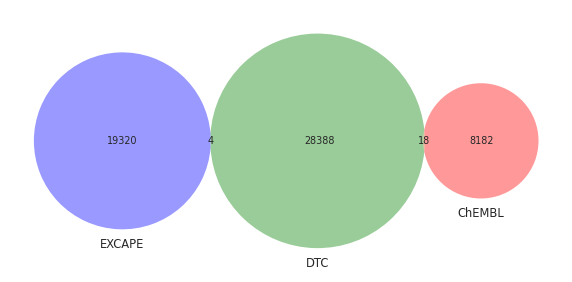

In [82]:
# overlaps from SMILES strings
venn3([set(chembl.Smiles),
           set(dtc.SMILES),
           set(excape.SMILES)],
          set_labels = ['ChEMBL', 'DTC','EXCAPE']);

### venn diagram 

For overlapping ChEMBL IDs - mpv requires sets not lists

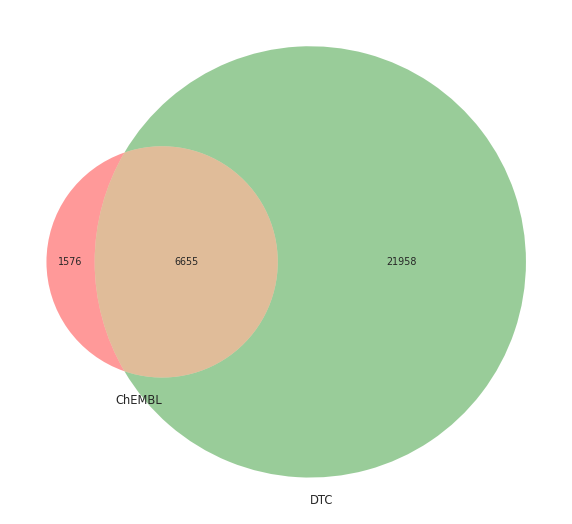

In [83]:
venn2([set(chembl.Molecule_ChEMBL_ID), set(dtc.compound_id)], set_labels=['ChEMBL','DTC']);

The chembl IDs overlap, why not the smiles strings? One explanation is that each database's SMILES string representations are slightly different. Answer? **STANDARDIZE the smiles strings.**

# **Curation step:** Standardize smiles strings, drop rows without base smiles

In [84]:
chembl['base_rdkit_smiles'] = chembl.Smiles.apply(curate_data.base_smiles_from_smiles)
print(len(chembl.Smiles))
print(len(chembl.Smiles.unique()))
print(len(chembl.base_rdkit_smiles.unique()))

9902
8200
8190


In [85]:
chembl[chembl.base_rdkit_smiles=='']

Molecule_ChEMBL_ID           Molecule_Name  Molecule_Max_Phase  \
28         CHEMBL136478    SODIUM NITROPRUSSIDE                 4.0   
668       CHEMBL1909067                     NaN                 0.0   
669       CHEMBL1909074    POLYVINYLPYRROLIDONE                 0.0   
739       CHEMBL1909055      COBALTOUS CHLORIDE                 4.0   
924       CHEMBL1201631                 INSULIN                 4.0   
...                 ...                     ...                 ...   
5676       CHEMBL414804             OXALIPLATIN                 4.0   
6205      CHEMBL1200693      MANGANESE CHLORIDE                 4.0   
6324      CHEMBL3559671       POLYVINYL ALCOHOL                 4.0   
7092       CHEMBL306043  GOLD SODIUM THIOMALATE                 4.0   
7667      CHEMBL1909069                     NaN                 0.0   

      Molecular_Weight  #RO5_Violations  AlogP             Compound_Key  \
28              261.92              NaN    NaN     SODIUM NITROPRUSSIDE   
668                NaN              NaN    NaN                MC 258714   
669                NaN              NaN    NaN     POLYVINYLPYRROLIDONE   
739             129.84              NaN    NaN     COBALT (II) CHLORIDE   
924                NaN              NaN    NaN                  INSULIN   
...                ...              ...    ...                      ...   
5676               NaN              NaN    NaN              OXALIPLATIN   
6205            125.84              NaN    NaN  MANGANESE (II) CHLORIDE   
6324               NaN              NaN    NaN        POLYVINYL ALCOHOL   
7092            346.11              NaN    NaN   GOLD SODIUM THIOMALATE   
7667               NaN              NaN    NaN                MC 288769   

     Smiles Standard_Type Standard_Relation  Standard_Value Standard_Units  \
28      NaN          IC50               NaN             NaN            NaN   
668     NaN          IC50               NaN             NaN            NaN   
669     NaN          IC50               NaN             NaN            NaN   
739     NaN          IC50               NaN             NaN            NaN   
924     NaN          IC50               NaN             NaN            NaN   
...     ...           ...               ...             ...            ...   
5676    NaN          IC50               NaN             NaN            NaN   
6205    NaN          IC50               NaN             NaN            NaN   
6324    NaN          IC50               NaN             NaN            NaN   
7092    NaN          IC50               NaN             NaN            NaN   
7667    NaN          IC50               NaN             NaN            NaN   

      pChEMBL_Value Data_Validity_Comment  \
28              NaN                   NaN   
668             NaN                   NaN   
669             NaN                   NaN   
739             NaN                   NaN   
924             NaN                   NaN   
...             ...                   ...   
5676            NaN                   NaN   
6205            NaN                   NaN   
6324            NaN                   NaN   
7092            NaN                   NaN   
7667            NaN                   NaN   

                                                Comment Uo_Units  \
28    Not Active (inhibition < 50% @ 10 uM and thus ...      NaN   
668   Not Active (inhibition < 50% @ 10 uM and thus ...      NaN   
669   Not Active (inhibition < 50% @ 10 uM and thus ...      NaN   
739   Not Active (inhibition < 50% @ 10 uM and thus ...      NaN   
924   Not Active (inhibition < 50% @ 10 uM and thus ...      NaN   
...                                                 ...      ...   
5676  Not Active (inhibition < 50% @ 10 uM and thus ...      NaN   
6205  Not Active (inhibition < 50% @ 10 uM and thus ...      NaN   
6324  Not Active (inhibition < 50% @ 10 uM and thus ...      NaN   
7092  Not Active (inhibition < 50% @ 10 uM and thus ...      NaN   
7667  Not Active (inhibit

In [86]:
chembl=chembl.replace('',np.nan)
chembl[chembl.base_rdkit_smiles.isna()]

Molecule_ChEMBL_ID           Molecule_Name  Molecule_Max_Phase  \
28         CHEMBL136478    SODIUM NITROPRUSSIDE                 4.0   
668       CHEMBL1909067                     NaN                 0.0   
669       CHEMBL1909074    POLYVINYLPYRROLIDONE                 0.0   
739       CHEMBL1909055      COBALTOUS CHLORIDE                 4.0   
924       CHEMBL1201631                 INSULIN                 4.0   
...                 ...                     ...                 ...   
5676       CHEMBL414804             OXALIPLATIN                 4.0   
6205      CHEMBL1200693      MANGANESE CHLORIDE                 4.0   
6324      CHEMBL3559671       POLYVINYL ALCOHOL                 4.0   
7092       CHEMBL306043  GOLD SODIUM THIOMALATE                 4.0   
7667      CHEMBL1909069                     NaN                 0.0   

      Molecular_Weight  #RO5_Violations  AlogP             Compound_Key  \
28              261.92              NaN    NaN     SODIUM NITROPRUSSIDE   
668                NaN              NaN    NaN                MC 258714   
669                NaN              NaN    NaN     POLYVINYLPYRROLIDONE   
739             129.84              NaN    NaN     COBALT (II) CHLORIDE   
924                NaN              NaN    NaN                  INSULIN   
...                ...              ...    ...                      ...   
5676               NaN              NaN    NaN              OXALIPLATIN   
6205            125.84              NaN    NaN  MANGANESE (II) CHLORIDE   
6324               NaN              NaN    NaN        POLYVINYL ALCOHOL   
7092            346.11              NaN    NaN   GOLD SODIUM THIOMALATE   
7667               NaN              NaN    NaN                MC 288769   

     Smiles Standard_Type Standard_Relation  Standard_Value Standard_Units  \
28      NaN          IC50               NaN             NaN            NaN   
668     NaN          IC50               NaN             NaN            NaN   
669     NaN          IC50               NaN             NaN            NaN   
739     NaN          IC50               NaN             NaN            NaN   
924     NaN          IC50               NaN             NaN            NaN   
...     ...           ...               ...             ...            ...   
5676    NaN          IC50               NaN             NaN            NaN   
6205    NaN          IC50               NaN             NaN            NaN   
6324    NaN          IC50               NaN             NaN            NaN   
7092    NaN          IC50               NaN             NaN            NaN   
7667    NaN          IC50               NaN             NaN            NaN   

      pChEMBL_Value Data_Validity_Comment  \
28              NaN                   NaN   
668             NaN                   NaN   
669             NaN                   NaN   
739             NaN                   NaN   
924             NaN                   NaN   
...             ...                   ...   
5676            NaN                   NaN   
6205            NaN                   NaN   
6324            NaN                   NaN   
7092            NaN                   NaN   
7667            NaN                   NaN   

                                                Comment Uo_Units  \
28    Not Active (inhibition < 50% @ 10 uM and thus ...      NaN   
668   Not Active (inhibition < 50% @ 10 uM and thus ...      NaN   
669   Not Active (inhibition < 50% @ 10 uM and thus ...      NaN   
739   Not Active (inhibition < 50% @ 10 uM and thus ...      NaN   
924   Not Active (inhibition < 50% @ 10 uM and thus ...      NaN   
...                                                 ...      ...   
5676  Not Active (inhibition < 50% @ 10 uM and thus ...      NaN   
6205  Not Active (inhibition < 50% @ 10 uM and thus ...      NaN   
6324  Not Active (inhibition < 50% @ 10 uM and thus ...      NaN   
7092  Not Active (inhibition < 50% @ 10 uM and thus ...      NaN   
7667  Not Active (inhibit

In [87]:
chembl=chembl[~chembl.base_rdkit_smiles.isna()]

In [88]:
chembl[chembl.base_rdkit_smiles=='']

Empty DataFrame
Columns: [Molecule_ChEMBL_ID, Molecule_Name, Molecule_Max_Phase, Molecular_Weight, #RO5_Violations, AlogP, Compound_Key, Smiles, Standard_Type, Standard_Relation, Standard_Value, Standard_Units, pChEMBL_Value, Data_Validity_Comment, Comment, Uo_Units, Ligand_Efficiency_BEI, Ligand_Efficiency_LE, Ligand_Efficiency_LLE, Ligand_Efficiency_SEI, Potential_Duplicate, Assay_ChEMBL_ID, Assay_Description, Assay_Type, BAO_Format_ID, BAO_Label, Assay_Organism, Assay_Tissue_ChEMBL_ID, Assay_Tissue_Name, Assay_Cell_Type, Assay_Subcellular_Fraction, Target_ChEMBL_ID, Target_Name, Target_Organism, Target_Type, Document_ChEMBL_ID, Source_ID, Source_Description, Document_Journal, Document_Year, Cell_ChEMBL_ID, Standard_Value_nM, base_rdkit_smiles]
Index: []

## Standardize other datasets
- what do you notice about the number of unique smiles strings before and after standardization?
- what does this mean for the nature of the compounds in a given dataset?
- hint: look at chemical identifiers that have the same base_rdkit_smiles, and the 'DB' column in excape

In [89]:
dtc['base_rdkit_smiles'] = dtc.SMILES.apply(curate_data.base_smiles_from_smiles)
print(len(dtc.SMILES))
print(len(dtc.SMILES.unique()))
print(len(dtc.base_rdkit_smiles.unique()))

47072
28410
28234


In [90]:
dtc=dtc.replace('',np.nan)
dtc[dtc.base_rdkit_smiles.isna()]

compound_id           standard_inchi_key     compound_name synonym  \
910    CHEMBL3542221  AHLSMWMHWYXLKD-UHFFFAOYSA-N               NaN     NaN   
4958             NaN  CLRSLRWKONPSRQ-IIPSPAQQSA-N        NVP-CGM097     NaN   
15596  CHEMBL3542423  JARPJCKJRYKPQY-PUUVEUEGSA-N               NaN     NaN   
33776  CHEMBL3542426  SOFCTBLAEJWBSR-PUUVEUEGSA-N               NaN     NaN   
39576  CHEMBL3542288  WJDAHOMWAHFHLZ-SHXYBYRDSA-N               NaN     NaN   
...              ...                          ...               ...     ...   
47059  CHEMBL2074618                          NaN  GRAPEFRUIT JUICE     NaN   
47060  CHEMBL2074618                          NaN  GRAPEFRUIT JUICE     NaN   
47061  CHEMBL2074721                          NaN          BANPEIYU     NaN   
47062  CHEMBL2074721                          NaN          BANPEIYU     NaN   
47063  CHEMBL2108102                          NaN   ST. JOHN'S WORT     NaN   

      target_id     target_pref_name gene_names wildtype_or_mutant  \
910      P08684  CYTOCHROME P450 3A4     CYP3A4                NaN   
4958     P08684  CYTOCHROME P450 3A4     CYP3A4          wild_type   
15596    P08684  CYTOCHROME P450 3A4     CYP3A4                NaN   
33776    P08684  CYTOCHROME P450 3A4     CYP3A4                NaN   
39576    P08684  CYTOCHROME P450 3A4     CYP3A4                NaN   
...         ...                  ...        ...                ...   
47059    P08183     P-GLYCOPROTEIN 1      ABCB1                NaN   
47060    P08183     P-GLYCOPROTEIN 1      ABCB1                NaN   
47061    P08183     P-GLYCOPROTEIN 1      ABCB1                NaN   
47062    P08183     P-GLYCOPROTEIN 1      ABCB1                NaN   
47063    P08183     P-GLYCOPROTEIN 1      ABCB1                NaN   

      mutation_info   pubmed_id    standard_type standard_relation  \
910             NaN  23474650.0  DRUG METABOLISM               NaN   
4958            NaN  26181851.0             IC50                 =   
15596           NaN  22517972.0  DRUG METABOLISM               NaN   
33776           NaN  22517972.0  DRUG METABOLISM               NaN   
39576           NaN  22829543.0  DRUG METABOLISM               NaN   
...             ...         ...              ...               ...   
47059           NaN  15258108.0         ACTIVITY               NaN   
47060           NaN  15258108.0         ACTIVITY               NaN   
47061           NaN  15258108.0         ACTIVITY               NaN   
47062           NaN  15258108.0         ACTIVITY               NaN   
47063           NaN  11180019.0         ACTIVITY               NaN   

       standard_value standard_units         activity_comment ep_action_mode  \
910               NaN            NaN      metabolite_detected            NaN   
4958          17000.0             NM                      NaN     inhibition   
15596             NaN            NaN      metabolite_detected            NaN   
33776             NaN            NaN      metabolite_detected            NaN   
39576             NaN            NaN  metabolite_not_detected            NaN   
...               ...            ...                      ...            ...   
47059             NaN            NaN            inhibitor [+]            NaN   
47060             NaN            NaN            inhibitor [+]            NaN   
47061             NaN            NaN            inhibitor [+]            NaN   
47062             NaN            NaN            inhibitor [+]            NaN   
47063             NaN            NaN              inducer [+]            NaN   

         assay_format   assaytype    assay_subtype inhibitor_type  \
910               NaN         NaN              NaN            NaN   
4958        cell_free  functional  enzyme_activity            NaN   
15596             NaN         NaN              NaN            NaN   
33776             NaN         NaN              NaN            NaN   
39576             NaN         NaN              NaN            NaN   
...

In [91]:
dtc=dtc[~dtc.base_rdkit_smiles.isna()]

In [92]:
excape['base_rdkit_smiles'] = excape.SMILES.apply(curate_data.base_smiles_from_smiles)

In [93]:
excape=excape.replace('',np.nan)
excape[excape.base_rdkit_smiles.isna()]
excape=excape[~excape.base_rdkit_smiles.isna()]

# **Curation step:** Save standardized datasets

If want to save the files for later use, mount your google drive and create a folder called `Columbia_E4511` and save it there. 

In [94]:
chembl.to_csv("/content/drive/MyDrive/Columbia_E4511/CYP3A4_ChEMBL_SMILES_std.csv")
dtc.to_csv("/content/drive/MyDrive/Columbia_E4511/CYP3A4_DTC_SMILES_std.csv")
excape.to_csv("/content/drive/MyDrive/Columbia_E4511/CYP3A4_Excape_SMILES_std.csv")

## Examine compound overlaps from standardized smiles strings
- create venn diagram with 3 circles for all 3 datasets

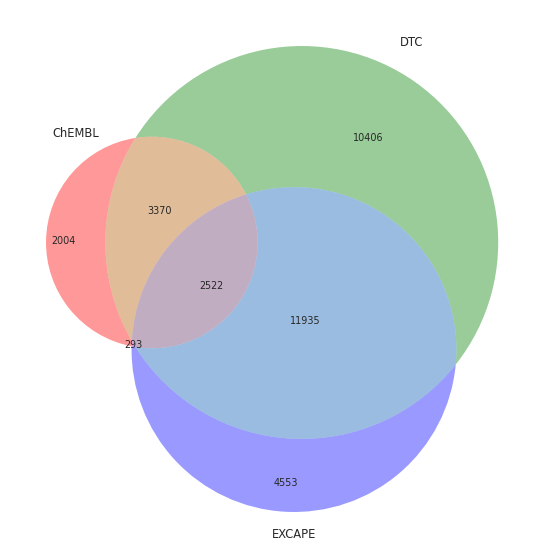

In [95]:
mpv.venn3([set(chembl.base_rdkit_smiles),
           set(dtc.base_rdkit_smiles),
           set(excape.base_rdkit_smiles)],
          set_labels = ['ChEMBL', 'DTC','EXCAPE']);

That's more like it. For even further overlaps, it's possible to pass all of them through the pubchem ID exchange: use input as smiles and output as smiles, then create base_rdkit_smiles again. You should see some increase in overlap with this pre-processing step.

# EDA: Examine compound diversity

 If you want to restart, you can start from here. Please uncomment the following code chunk 

In [ ]:
chembl=pd.read_csv("/content/drive/MyDrive/Columbia_E4511/CYP3A4_ChEMBL_SMILES_std.csv", index_col=0)
dtc=pd.read_csv("/content/drive/MyDrive/Columbia_E4511/CYP3A4_DTC_SMILES_std.csv", index_col=0)
excape=pd.read_csv("/content/drive/MyDrive/Columbia_E4511/CYP3A4_Excape_SMILES_std.csv", index_col=0)

In [96]:
from rdkit import Chem
from rdkit.Chem import AllChem, Draw
from rdkit.DataManip.Metric.rdMetricMatrixCalc import GetTanimotoDistMat

import umap
from scipy.stats.kde import gaussian_kde
from scipy.cluster.hierarchy import linkage

ndist_max = 1000000

def plot_tani_dist_distr(dataset, smiles_col, dataset_name, **metric_kwargs):
    """
    Generate a density plot showing the distribution of distances between ecfp feature
    vectors, using the tanimoto metric.
    """
    # log = logging.getLogger('ATOM')
    num_cmpds = len(dataset)
    if num_cmpds > 50000:
        log.warning("Dataset has %d compounds, too big to calculate distance matrix" % num_cmpds)
        return

    # log.warning("Starting distance matrix calculation for %d compounds" % num_cmpds)
    feat_type = 'ecfp'
    dist_metric = 'tanimoto'
    smiles_arr1 = dataset[smiles_col].values
    mols1 = [Chem.MolFromSmiles(s) for s in smiles_arr1]
    fprints1 = [AllChem.GetMorganFingerprintAsBitVect(mol, 2, 1024) for mol in mols1]
    dists = GetTanimotoDistMat(fprints1)

    # log.warning("Finished calculation of %d distances" % len(dists))

    if len(dists) > ndist_max:
        # Sample a subset of the distances so KDE doesn't take so long
        dist_sample = np.random.choice(dists, size=ndist_max)
    else:
        dist_sample = dists

    dist_pdf = gaussian_kde(dist_sample)
    x_plt = np.linspace(min(dist_sample), max(dist_sample), 500)
    y_plt = dist_pdf(x_plt)
    fig, ax = plt.subplots(figsize=(8.0,8.0))
    ax.plot(x_plt, y_plt)
    ax.set_xlabel('%s distance' % dist_metric)
    ax.set_ylabel('Density')
    ax.set_title("%s dataset\nDistribution of %s distances between %s feature vectors" % (
                  dataset_name, dist_metric, feat_type))
    return dists


In [ ]:
sns.set_context('poster')

array([0.86607143, 0.85849057, 0.23076923, ..., 0.86065574, 0.872     ,
       0.84920635])

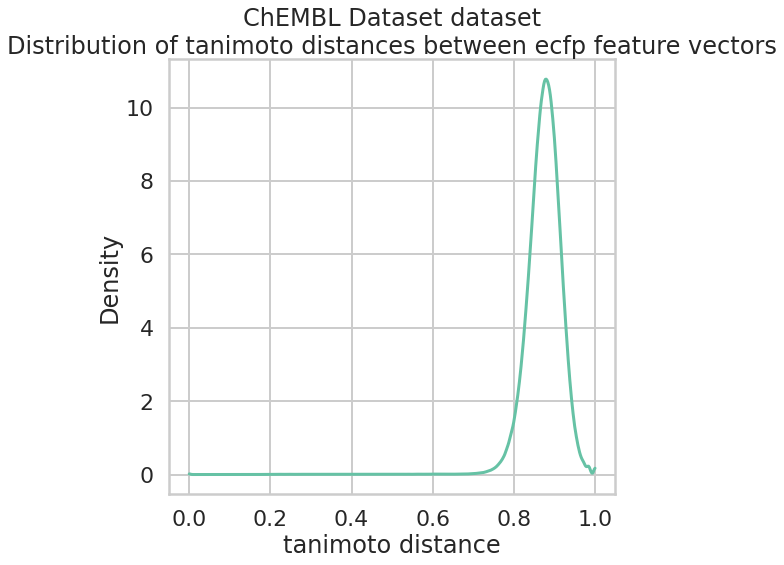

In [ ]:
plot_tani_dist_distr(chembl, 'base_rdkit_smiles', 'ChEMBL Dataset')

In [ ]:
chembl[['Molecule_ChEMBL_ID','base_rdkit_smiles','pChEMBL_Value']].head(3)

Molecule_ChEMBL_ID                                  base_rdkit_smiles  \
0       CHEMBL240954  CC(=O)O[C@H]1[C@H](C)O[C@@H](Oc2c(-c3ccc(O)cc3...   
1       CHEMBL393363  CCc1nc(N)nc(N)c1-c1ccc2c(c1)N(CCNC(C)=O)C(=O)C...   
2       CHEMBL398584  CCc1nc(N)nc(N)c1-c1ccc2c(c1)N(CCNC(C)=O)C(=O)C...   

   pChEMBL_Value  
0           4.69  
1           6.92  
2           6.07

Computing fingerprints...
Done
Computing Tanimoto distance matrix...
Done


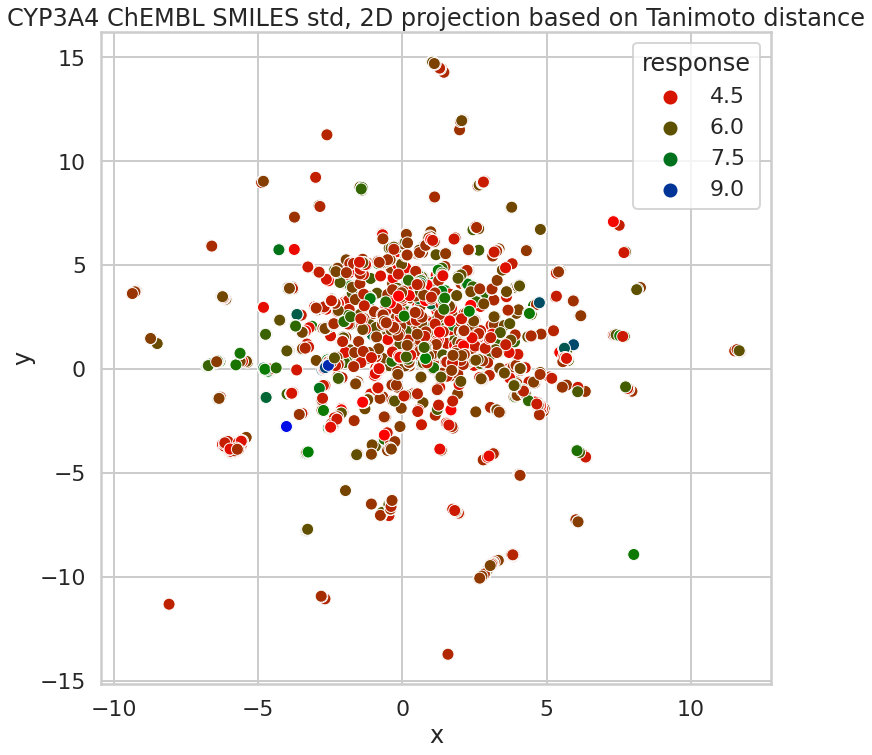

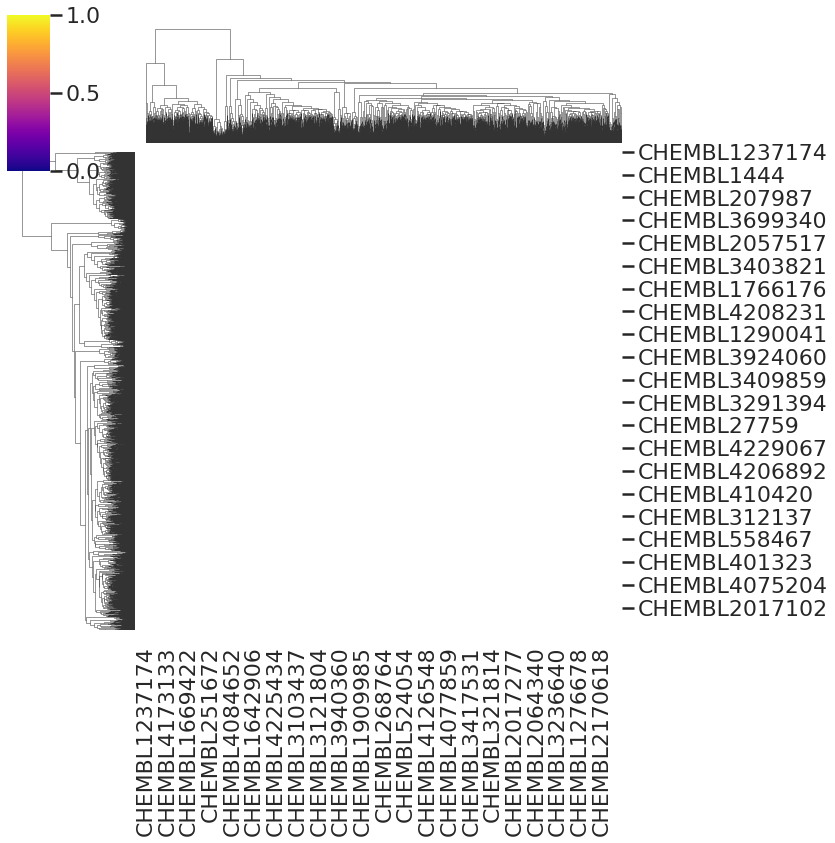

In [ ]:
dp.diversity_plots(dset_key='/content/drive/MyDrive/Columbia_E4511/CYP3A4_ChEMBL_SMILES_std.csv',
                   datastore=False, 
                   id_col ='Molecule_ChEMBL_ID', 
                   smiles_col = 'base_rdkit_smiles', 
                   is_base_smiles=True, 
                   response_col = 'pChEMBL_Value')

## Create plots for DTC, Excape
- What happens when you change the ecfp radius?
- bonus: try creating MCS plots by looking at the documentation of the diversity_plots function
- warning: it is very slow for >1000 ish compounds. 
- extra bonus: select a random subset of 1000 compounds and create the MCS plots.

In [97]:
dtc['base_rdkit_smiles']

0                O=C1NC(=O)c2cc(Nc3ccccc3)c(Nc3ccccc3)cc21
1                O=C1NC(=O)c2cc(Nc3ccccc3)c(Nc3ccccc3)cc21
2        CONC(=O)Nc1ccc(-c2sc3c(c2CN(C)CCc2ccccn2)c(=O)...
3        CCNC(=O)C[C@@H]1N=C(c2ccc(Cl)cc2)c2cc(OC)ccc2-...
4        CCNC(=O)C[C@@H]1N=C(c2ccc(Cl)cc2)c2cc(OC)ccc2-...
                               ...                        
47067    Cn1c(=O)n(CC(C)(C)C)c2ccc(-c3cc(C(C)(C)O)ccc3C...
47068        Cc1ccc(CO)cc1-c1ccc2c(n1)n(C)c(=O)n2CC(C)(C)C
47069        Cc1ccc(CO)cc1-c1ccc2c(n1)n(C)c(=O)n2CC(C)(C)C
47070    Cc1ccc(C(C)(C)O)cc1-c1ccc2c(n1)n(C)c(=O)n2CC(C...
47071    Cc1ccc(C(C)(C)O)cc1-c1ccc2c(n1)n(C)c(=O)n2CC(C...
Name: base_rdkit_smiles, Length: 46765, dtype: object

In [ ]:
# Because we made some changes to DTC. We need to get the std SMILES again

In [ ]:
# dtc['base_rdkit_smiles'] = dtc.SMILES.apply(curate_data.base_smiles_from_smiles)
# dtc.to_csv("/content/drive/MyDrive/Columbia_E4511/HTR3A_DTC_SMILES_std.csv")

In [ ]:
# dtc=pd.read_csv("/content/drive/MyDrive/Columbia_E4511/HTR3A_DTC_SMILES_std.csv", index_col=0)

In [ ]:
plot_tani_dist_distr(dtc, 'base_rdkit_smiles', 'DTC dataset') # check for NA or other types

In [100]:
dtc[['compound_id','base_rdkit_smiles','pDTC_Value']]

compound_id                                  base_rdkit_smiles  \
0       CHEMBL268868          O=C1NC(=O)c2cc(Nc3ccccc3)c(Nc3ccccc3)cc21   
1       CHEMBL268868          O=C1NC(=O)c2cc(Nc3ccccc3)c(Nc3ccccc3)cc21   
2      CHEMBL1800663  CONC(=O)Nc1ccc(-c2sc3c(c2CN(C)CCc2ccccn2)c(=O)...   
3      CHEMBL1232461  CCNC(=O)C[C@@H]1N=C(c2ccc(Cl)cc2)c2cc(OC)ccc2-...   
4      CHEMBL1232461  CCNC(=O)C[C@@H]1N=C(c2ccc(Cl)cc2)c2cc(OC)ccc2-...   
...              ...                                                ...   
47067  CHEMBL3763754  Cn1c(=O)n(CC(C)(C)C)c2ccc(-c3cc(C(C)(C)O)ccc3C...   
47068  CHEMBL3765537      Cc1ccc(CO)cc1-c1ccc2c(n1)n(C)c(=O)n2CC(C)(C)C   
47069  CHEMBL3765537      Cc1ccc(CO)cc1-c1ccc2c(n1)n(C)c(=O)n2CC(C)(C)C   
47070  CHEMBL3765778  Cc1ccc(C(C)(C)O)cc1-c1ccc2c(n1)n(C)c(=O)n2CC(C...   
47071  CHEMBL3765778  Cc1ccc(C(C)(C)O)cc1-c1ccc2c(n1)n(C)c(=O)n2CC(C...   

       pDTC_Value  
0        5.799998  
1        5.799998  
2       64.000000  
3        4.481486  
4             NaN  
...           ...  
47067   65.000000  
47068    4.522879  
47069   13.000000  
47070    4.522879  
47071   22.000000  

[46765 rows x 3 columns]

Computing fingerprints...
Done
Computing Tanimoto distance matrix...
Done


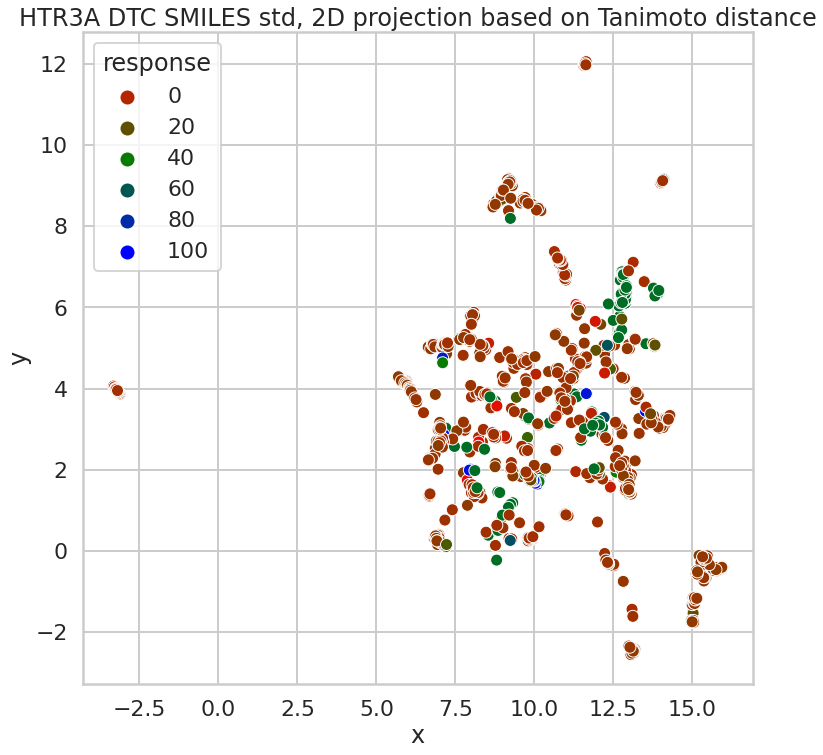

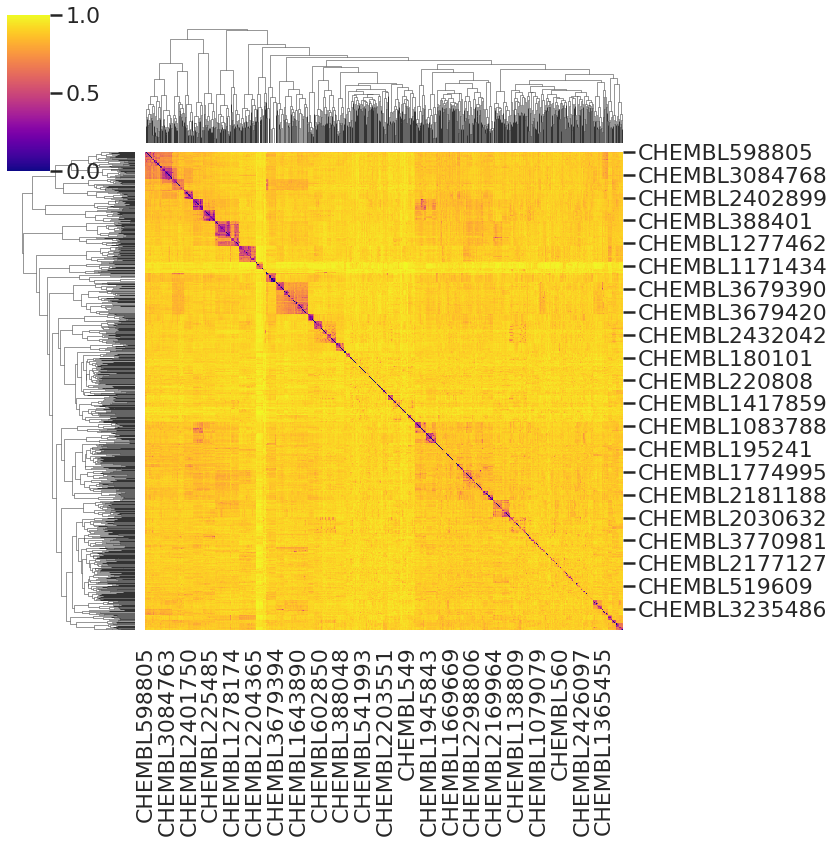

In [ ]:
dp.diversity_plots('/content/drive/MyDrive/Columbia_E4511/CYP3A4_DTC_SMILES_std.csv',
                   datastore=False, 
                   id_col ='compound_id', 
                   smiles_col = 'base_rdkit_smiles', 
                   is_base_smiles=True, 
                   response_col = 'pDTC_Value')

array([0.86842105, 0.90789474, 0.40983607, ..., 0.22058824, 0.77777778,
       0.77777778])

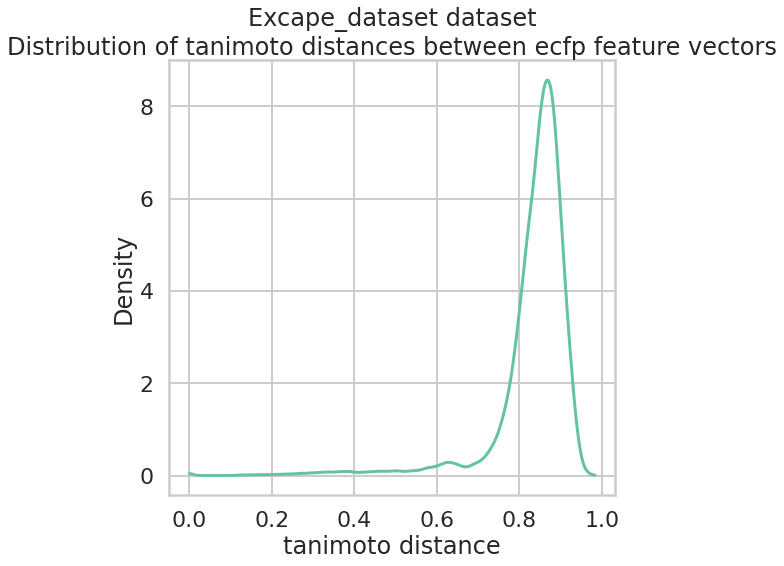

In [ ]:
plot_tani_dist_distr(excape, 'base_rdkit_smiles', 'Excape_dataset')

In [ ]:
excape.columns


Index(['Ambit_InchiKey', 'Original_Entry_ID', 'Entrez_ID', 'Activity_Flag',
       'pXC50', 'DB', 'Original_Assay_ID', 'Tax_ID', 'Gene_Symbol',
       'Ortholog_Group', 'SMILES', 'base_rdkit_smiles'],
      dtype='object')

Computing fingerprints...
Done
Computing Tanimoto distance matrix...
Done


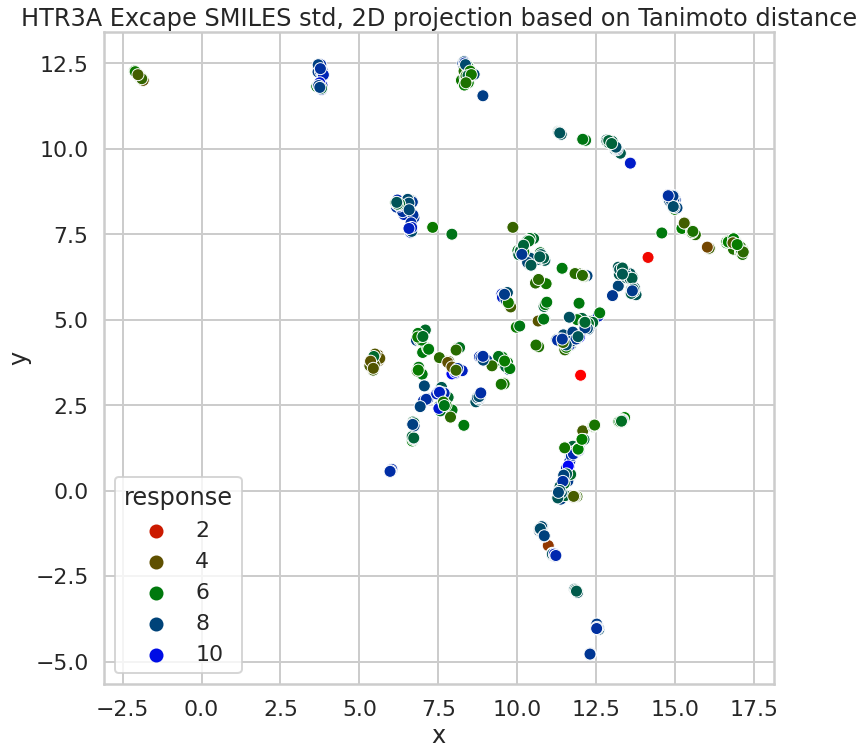

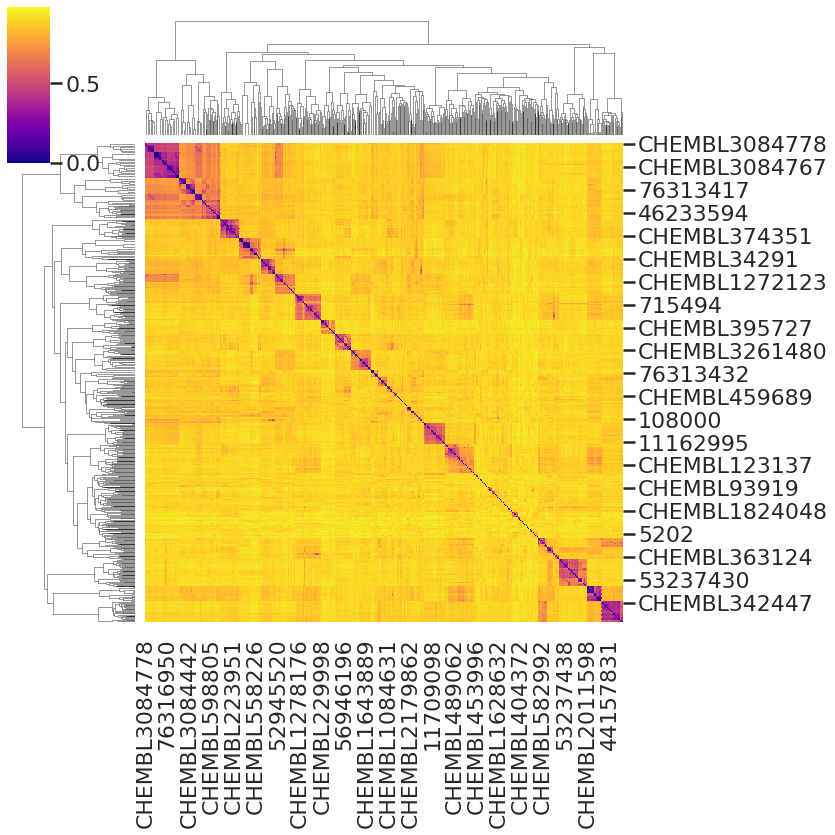

In [ ]:
dp.diversity_plots('/content/drive/MyDrive/Columbia_E4511/CYP3A4_Excape_SMILES_std.csv',
                   datastore=False, 
                   id_col ='Original_Entry_ID', 
                   smiles_col = 'base_rdkit_smiles', 
                   is_base_smiles=True, 
                   response_col = 'pXC50')

## Discussion on the analysis of the heatmap and density plots
```
what are Morgan fingerprints (ecfp)? 
what does radius mean?
what does a bit in an ECFP vector correspond to?
what radius and vector length are used in these functions?
hint: look at the .py files for more info
```
ECFP fingerprints are a bit vector representation of a compound's structure. Each bit represents the presence or absence of a certain 'connectivity' between atoms in a molecule. The radius used in the diversity plots function is radius 4 and length 1024. The tanimoto plot function uses radius 2. Radius means number of atoms you travel away from the given atom to assess connectivity, allowing you to look at larger or smaller molecule fragments.


```
what is tanimoto distance? What do values closer to zero or closer to one mean?
Do you think your sets of compounds are diverse?
What do you observe from the 2D projection of compounds?
Are there any similarities between groups of compounds in your datasets?
```

Tanimoto similarity (or jaccard index) represents how well two bit vectors overlap. Thus, distance represents how 'far' away they are from perfect overlap. A distance closer 1 means the fingerprints (and therefore molecules) are less similar to each other. A distance closer to zero means molecules are more similar. 

Compounds that are shown in this exercise have average tanimoto distances ~ 0.85 - 0.9, so they are fairly diverse.

In the ChEMBL dataset, the 2D project separates high and low pChEMBL values very well. The DTC and Excape datasets don't separate as well, but DTC also is on a very different scale.

From the heatmap, we can see clusters/squares of compounds with tanimoto distance closer to zero (purple) so I suspect there are some groups of compounds that are very similar.


# EDA: Curated data
- First let us curate the data
- Examine new compound overlaps
- Examine final response column distributions
- Filter for 
  - large compounds
  - too high / too low pXC50 values
- double check for no NA values left
- save final curated dataset for further processing

Start here if you want to restart from here. Dont forget to uncomment the following code chunk

In [ ]:
# chembl=pd.read_csv("/content/drive/MyDrive/Columbia_E4511/HTR3A_ChEMBL_SMILES_std.csv", index_col=0)
# dtc=pd.read_csv("/content/drive/MyDrive/Columbia_E4511/HTR3A_DTC_SMILES_std.csv", index_col=0)
# excape=pd.read_csv("/content/drive/MyDrive/Columbia_E4511/HTR3A_Excape_SMILES_std.csv", index_col=0)

In [101]:
# rescue NA pChemblValues
chembl['pChEMBL_Value_nM'] = -np.log10(chembl.Standard_Value_nM/1000000000)


In [102]:
chembl.head(3)

Molecule_ChEMBL_ID Molecule_Name  Molecule_Max_Phase  Molecular_Weight  \
0       CHEMBL240954           NaN                 0.0            516.46   
1       CHEMBL393363           NaN                 0.0            528.54   
2       CHEMBL398584           NaN                 0.0            496.52   

   #RO5_Violations  AlogP Compound_Key  \
0              2.0   1.92            9   
1              1.0   3.67       29-rac   
2              0.0   2.93       26-rac   

                                              Smiles Standard_Type  \
0  CC(=O)O[C@H]1[C@H](C)O[C@@H](Oc2c(-c3ccc(O)cc3...          IC50   
1  CCc1nc(N)nc(N)c1-c1ccc2c(c1)N(CCNC(C)=O)C(=O)C...          IC50   
2  CCc1nc(N)nc(N)c1-c1ccc2c(c1)N(CCNC(C)=O)C(=O)C...          IC50   

  Standard_Relation  Standard_Value Standard_Units  pChEMBL_Value  \
0               '='         20600.0             nM           4.69   
1               '='           120.0             nM           6.92   
2               '='           860.0             nM           6.07   

  Data_Validity_Comment Comment    Uo_Units  Ligand_Efficiency_BEI  \
0                   NaN     NaN  UO_0000065                    NaN   
1                   NaN     NaN  UO_0000065                    NaN   
2                   NaN     NaN  UO_0000065                    NaN   

   Ligand_Efficiency_LE  Ligand_Efficiency_LLE  Ligand_Efficiency_SEI  \
0                   NaN                    NaN                    NaN   
1                   NaN                    NaN                    NaN   
2                   NaN                    NaN                    NaN   

   Potential_Duplicate Assay_ChEMBL_ID  \
0                False   CHEMBL1000805   
1                False    CHEMBL898579   
2                False    CHEMBL898579   

                                 Assay_Description Assay_Type BAO_Format_ID  \
0  Inhibition of human CYP3A4 by radiometric assay          A   BAO_0000357   
1                             Inhibition of CYP3A4          A   BAO_0000357   
2                             Inhibition of CYP3A4          A   BAO_0000357   

               BAO_Label Assay_Organism Assay_Tissue_ChEMBL_ID  \
0  single protein format   Homo sapiens                    NaN   
1  single protein format            NaN                    NaN   
2  single protein format            NaN                    NaN   

  Assay_Tissue_Name Assay_Cell_Type Assay_Subcellular_Fraction  \
0               NaN             NaN                        NaN   
1               NaN             NaN                        NaN   
2               NaN             NaN                        NaN   

  Target_ChEMBL_ID          Target_Name Target_Organism     Target_Type  \
0        CHEMBL340  Cytochrome P450 3A4    Homo sapiens  SINGLE PROTEIN   
1        CHEMBL340  Cytochrome P450 3A4    Homo sapiens  SINGLE PROTEIN   
2        CHEMBL340  Cytochrome P450 3A4    Homo sapiens  SINGLE PROTEIN   

  Document_ChEMBL_ID  Source_ID     Source_Description    Document_Journal  \
0      CHEMBL1151241          1  Scientific Literature       J. Nat. Prod.   
1      CHEMBL1149625          1  Scientific Literature  Bioorg. Med. Chem.   
2      CHEMBL1149625          1  Scientific Literature  Bioorg. Med. Chem.   

   Document_Year Cell_ChEMBL_ID  Standard_Value_nM  \
0         2004.0            NaN            20600.0   
1         2007.0            NaN              120.0   
2         2007.0            NaN              860.0   

                                   base_rdkit_smiles  pChEMBL_Value_nM  
0  CC(=O)O[C@H]1[C@H](C)O[C@@H](Oc2c(-c3ccc(O)cc3...          4.686133  
1  CCc1nc(N)nc(N)c1-c1ccc2c(c1)N(CCNC(C)=O)C(=O)C...          6.920819  
2  CCc1nc(N)nc(N)c1-c1ccc2c(c1)N(CCNC(C)=O)C(=O)C...          6.065502

In [103]:
chembl.Standard_Type.unique()

array(['IC50'], dtype=object)

In [104]:
# select pIC50 values
vals = ['IC50']
print(chembl.shape)
chembl=chembl[chembl.Standard_Type.isin(vals)]
print(chembl.shape)

(9870, 44)
(9870, 44)


In [105]:
# drop NA pIC50's & smiles
chembl=chembl.dropna(axis=0, subset = ['pChEMBL_Value_nM','base_rdkit_smiles'])
print(chembl.shape)

(8629, 44)


In [106]:
# note weird punctuation
chembl.Standard_Relation.unique()

array(["'='", "'>'", "'<'", "'>='", "'<='", nan], dtype=object)

In [107]:
# flip arrows and fix punctuation for relation column to reflect pValues not normal values
chembl['pRelation'] = chembl.Standard_Relation
chembl['pRelation'] = np.where(chembl.Standard_Relation == "'<'", ">", chembl.pRelation)
chembl['pRelation'] = np.where(chembl.Standard_Relation == "'>'", "<", chembl.pRelation)
chembl['pRelation'] = np.where(chembl.Standard_Relation == "'='", "=", chembl.pRelation)
chembl[['Standard_Relation', 'pRelation']].head()

Standard_Relation pRelation
0               '='         =
1               '='         =
2               '='         =
3               '>'         <
4               '>'         <

In [108]:
thresh=-np.log10(100/1000000000) # pIC50 of 100nM for threshold

In [109]:
print(chembl.shape)
chembl_cur = curate_data.aggregate_assay_data(chembl, value_col = 'pChEMBL_Value_nM', 
                                              output_value_col = 'pXC50',
                                              id_col = 'Molecule_ChEMBL_ID', 
                                              smiles_col = 'base_rdkit_smiles',
                                              relation_col = 'pRelation',
                                              active_thresh=thresh)
print(chembl_cur.shape)
chembl_cur.head()

(8629, 45)
0 entries in input table are missing SMILES strings
7084 unique SMILES strings are reduced to 7082 unique base SMILES strings
(7082, 5)


compound_id                                  base_rdkit_smiles relation  \
0  CHEMBL3422242  Cc1cc([C@H]2C[C@H]3[C@@H](C)SC(N)=N[C@@]3(c3cc...        <   
1   CHEMBL502182  COc1cccc(-c2c(C)n(Cc3c(F)cccc3C(F)(F)F)c(=O)n(...            
2   CHEMBL389608  COc1cccc(N2C(=O)N(Cc3ccccc3F)C3(CCN(Cc4ccc(-c5...            
3   CHEMBL453384           CC(C)(C)NCc1cc(Nc2ccnc3cc(Cl)ccc23)ccc1F        <   
4  CHEMBL1277312        O=C(O)C1CN(C2CCC3(Cc4ccccc4Oc4ccccc43)C2)C1        <   

      pXC50  active  
0  4.522879       0  
1  4.251812       0  
2  5.958607       0  
3  4.000000       0  
4  5.000000       0

In [110]:
chembl_cur.to_csv("/content/drive/MyDrive/Columbia_E4511/CYP3A4_ChEMBL_cur.csv")

In [111]:
# DTC
# select pIC50 values
vals = ['IC50', 'PIC50']
print(dtc.shape)
dtc=dtc[dtc.standard_type.isin(vals)]
print(dtc.shape)

# flip arrows for relation column to reflect pValues not normal values
dtc['pRelation'] = dtc.standard_relation
dtc['pRelation'] = np.where(dtc.standard_relation == "<", ">", dtc.pRelation)
dtc['pRelation'] = np.where(dtc.standard_relation == ">", "<", dtc.pRelation)
dtc['pRelation'] = np.where(dtc.standard_relation == "=", "=", dtc.pRelation)
print(dtc.pRelation.unique())
display(dtc[['standard_relation', 'pRelation']].head())

dtc=dtc.dropna(axis=0, subset = ['pDTC_Value','base_rdkit_smiles'])
print(dtc.shape)

# aggregate duplicates
dtc_cur = curate_data.aggregate_assay_data(dtc, value_col = 'pDTC_Value', 
                                              output_value_col = 'pXC50',
                                              id_col = 'compound_id', 
                                              smiles_col = 'base_rdkit_smiles',
                                              relation_col = 'pRelation',
                                              active_thresh=thresh)
dtc_cur.to_csv("/content/drive/MyDrive/Columbia_E4511/CYP3A4_DTC_cur.csv")
print(dtc_cur.shape)
print(dtc_cur.relation.unique())
dtc_cur.head()

(46765, 36)
(8946, 36)
['>=' '<' nan '=' '>' '<=']


standard_relation pRelation
3                 >=        >=
15                 >         <
52               NaN       NaN
56                 >         <
59                 =         =

(7820, 37)
0 entries in input table are missing SMILES strings
5823 unique SMILES strings are reduced to 5822 unique base SMILES strings
(5822, 5)
['<' '' '>']


compound_id                                  base_rdkit_smiles relation  \
0  CHEMBL3422242  Cc1cc([C@H]2C[C@H]3[C@@H](C)SC(N)=N[C@@]3(c3cc...        <   
1   CHEMBL502182  COc1cccc(-c2c(C)n(Cc3c(F)cccc3C(F)(F)F)c(=O)n(...            
2  CHEMBL3216313               CN(C)CCN1CCCc2cc(N=C(N)c3cccs3)ccc21        <   
3   CHEMBL389608  COc1cccc(N2C(=O)N(Cc3ccccc3F)C3(CCN(Cc4ccc(-c5...            
4   CHEMBL453384           CC(C)(C)NCc1cc(Nc2ccnc3cc(Cl)ccc23)ccc1F        <   

      pXC50  active  
0  4.522879       0  
1  4.251812       0  
2  4.000000       0  
3  5.958607       0  
4  4.000000       0

In [112]:
# excape: has no relation col, so create one with all ''
excape['pRelation']=''
print(excape.shape)
print(excape.pRelation.unique())
excape=excape.dropna(axis=0, subset = ['pXC50','base_rdkit_smiles'])
print(excape.shape)
# aggregate duplicates
excape_cur = curate_data.aggregate_assay_data(excape, value_col = 'pXC50', 
                                              output_value_col = 'pXC50',
                                              id_col = 'Original_Entry_ID', 
                                              smiles_col = 'base_rdkit_smiles',
                                              relation_col = 'pRelation',
                                              active_thresh=thresh)
excape_cur.to_csv("/content/drive/MyDrive/Columbia_E4511/CYP3A4_Excape_cur.csv")
print(excape_cur.shape)
print(excape_cur.relation.unique())
excape_cur.head()

(19315, 13)
['']
(14385, 13)
0 entries in input table are missing SMILES strings
14374 unique SMILES strings are reduced to 14372 unique base SMILES strings
(14372, 5)
['']


compound_id                                base_rdkit_smiles relation  \
0  CHEMBL1537880          Cc1ccc(-c2nnc(C)c(N3CC(C)OC(C)C3)n2)cc1            
1  CHEMBL1515033         CS(=O)(=O)N1CCC[C@@]2(CCN(c3ccncc3)C2)C1            
2  CHEMBL1526043  N#Cc1cccc(-c2nc3cnc(N4CCOCC4)nc3n(C3CC3)c2=O)c1            
3  CHEMBL3145019               Cc1nn(C(C)(C)C)c(O)c1Sc1ccc(Cl)cc1            
4        3035746              N/C(=N/CCc1ccc(I)cc1)SCCCc1cnc[nH]1            

     pXC50  active  
0  5.30000       0  
1  5.10000       0  
2  4.40000       0  
3  4.80000       0  
4  6.10002       0

In [113]:
chembl_cur['datasource'] = 'chembl'
dtc_cur['datasource']='dtc'
excape_cur['datasource']='excape'
CYP3A4 = pd.concat([chembl_cur, dtc_cur, excape_cur])
CYP3A4.to_csv("/content/drive/MyDrive/Columbia_E4511/CYP3A4_merge.csv")
print(CYP3A4.shape)

(27276, 6)


In [114]:
CYP3A4=CYP3A4.fillna("")

In [115]:
import importlib
importlib.reload(curate_data)
CYP3A4_cur = curate_data.aggregate_assay_data(CYP3A4, value_col = 'pXC50', 
                                              id_col = 'compound_id', 
                                              smiles_col = 'base_rdkit_smiles',
                                              relation_col = 'relation',
                                              active_thresh=thresh)

print(CYP3A4_cur.shape)
print(CYP3A4.relation.unique())
CYP3A4_cur.head()

0 entries in input table are missing SMILES strings
19637 unique SMILES strings are reduced to 19637 unique base SMILES strings
(19637, 5)
['<' '' '>']


compound_id                                  base_rdkit_smiles relation  \
0  CHEMBL1537880            Cc1ccc(-c2nnc(C)c(N3CC(C)OC(C)C3)n2)cc1            
1  CHEMBL1515033           CS(=O)(=O)N1CCC[C@@]2(CCN(c3ccncc3)C2)C1            
2  CHEMBL3422242  Cc1cc([C@H]2C[C@H]3[C@@H](C)SC(N)=N[C@@]3(c3cc...        <   
3  CHEMBL1526043    N#Cc1cccc(-c2nc3cnc(N4CCOCC4)nc3n(C3CC3)c2=O)c1            
4  CHEMBL3145019                 Cc1nn(C(C)(C)C)c(O)c1Sc1ccc(Cl)cc1            

      pXC50  active  
0  5.300000       0  
1  5.100000       0  
2  4.522879       0  
3  4.400000       0  
4  4.800000       0

In [116]:
CYP3A4_cur.relation.unique()

array(['', '<', '>'], dtype=object)

In [117]:
CYP3A4_cur[CYP3A4_cur['pXC50']>=50]

compound_id                                  base_rdkit_smiles  \
5352   CHEMBL520129  O=C(Nc1ccc2cnn(S(=O)(=O)c3cccc4ccccc34)c2c1)C1...   
8525  CHEMBL3740472  COCCCN1C[C@H]2[C@H](CNC(=O)c3nc(C(C)C)n4ccccc3...   

     relation       pXC50  active  
5352           133.292513       1  
8525                  inf       1

In [118]:
CYP3A4_cur.drop([8525],inplace=True)

In [119]:
CYP3A4_cur.reset_index(drop=True, inplace=True)

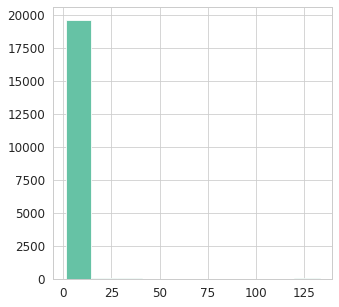

In [120]:
CYP3A4_cur.pXC50.hist(figsize=(5,5));

In [121]:
CYP3A4_cur.active.sum()

509

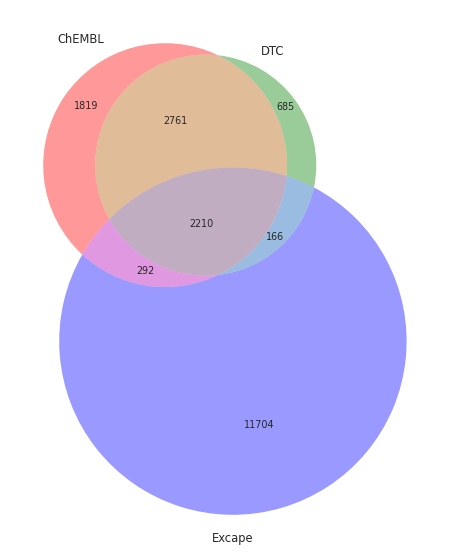

In [122]:
mpv.venn3([set(CYP3A4.loc[CYP3A4.datasource=='chembl','base_rdkit_smiles']),
           set(CYP3A4.loc[CYP3A4.datasource=='dtc','base_rdkit_smiles']),
           set(CYP3A4.loc[CYP3A4.datasource=='excape','base_rdkit_smiles']),],
          set_labels = ['ChEMBL','DTC','Excape']);

2021-03-25 18:51:08,731 *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


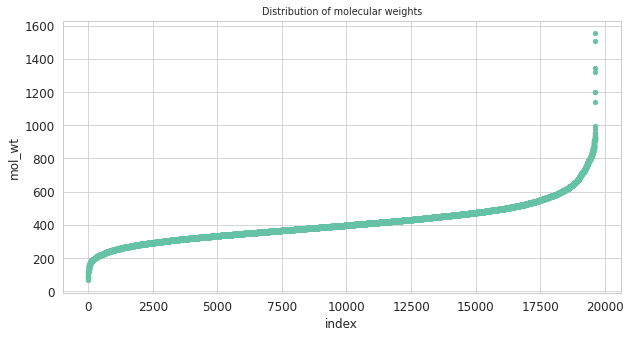

In [124]:
CYP3A4_cur["mol_wt"] = [Chem.Descriptors.ExactMolWt(Chem.MolFromSmiles(smile)) for smile in CYP3A4_cur["base_rdkit_smiles"]]
CYP3A4_cur = CYP3A4_cur.sort_values('mol_wt')
CYP3A4_cur=CYP3A4_cur.reset_index(drop=True)
CYP3A4_cur=CYP3A4_cur.reset_index() # plot x axis as index #'s
fig,ax=plt.subplots(figsize=(10,5))
CYP3A4_cur.plot(kind='scatter', x='index', y='mol_wt', ax=ax);
plt.title("Distribution of molecular weights");

In [126]:
print(CYP3A4_cur.shape)
CYP3A4_cur = CYP3A4_cur[CYP3A4_cur.mol_wt <1400]
print(CYP3A4_cur.shape)

(19636, 7)
(19634, 7)


2021-03-18 23:35:45,798 *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


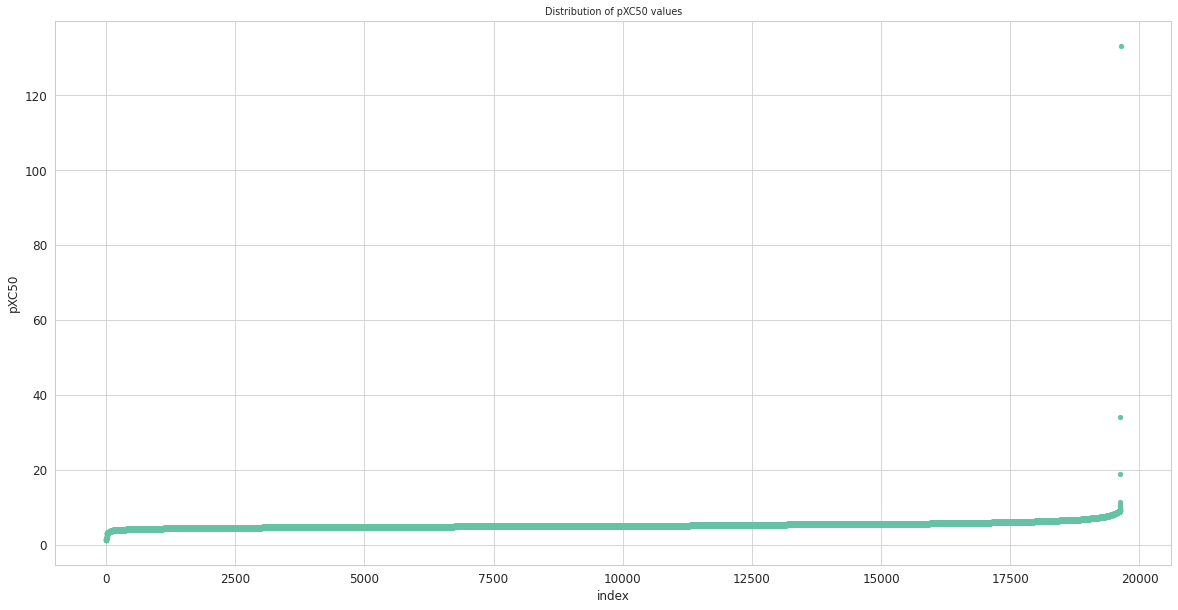

In [ ]:
CYP3A4_cur=CYP3A4_cur.drop(columns=['index'])
CYP3A4_cur = CYP3A4_cur.sort_values('pXC50')
CYP3A4_cur = CYP3A4_cur.reset_index(drop=True)
CYP3A4_cur = CYP3A4_cur.reset_index() # plot x axis as index #'s
fig,ax=plt.subplots(figsize=(20,10))
CYP3A4_cur.plot(kind='scatter', x='index', y='pXC50', ax=ax);
plt.title("Distribution of pXC50 values");

In [127]:
print(CYP3A4_cur.shape)
CYP3A4_cur=CYP3A4_cur[CYP3A4_cur.pXC50>2]
CYP3A4_cur=CYP3A4_cur[CYP3A4_cur.pXC50<14]
print(CYP3A4_cur.shape)

(19634, 7)
(19617, 7)


In [128]:
for col in CYP3A4_cur.columns:
  print(col, CYP3A4_cur[col].isna().values.any())

index False
compound_id False
base_rdkit_smiles False
relation False
pXC50 False
active False
mol_wt False


array([0.9       , 0.91304348, 0.76      , ..., 0.78761062, 0.81451613,
       0.85964912])

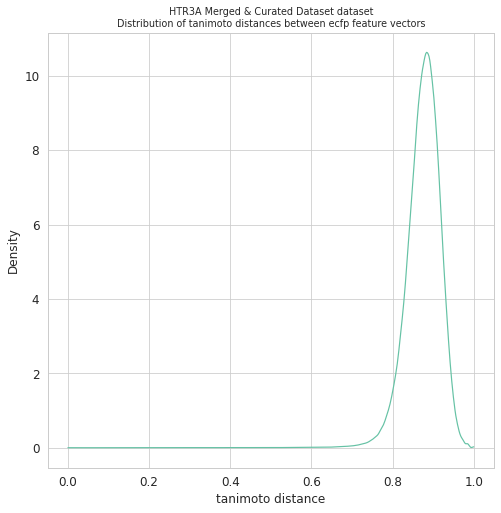

In [ ]:
plot_tani_dist_distr(CYP3A4_cur, 'base_rdkit_smiles', 'CYP3A4 Merged & Curated Dataset')

In [129]:
CYP3A4_cur.to_csv("/content/drive/MyDrive/Columbia_E4511/CYP3A4_cur.csv")

In [ ]:
dp.diversity_plots('/content/drive/MyDrive/Columbia_E4511/CYP3A4_cur.csv', 
                   datastore = False,
                   id_col ='compound_id', 
                   smiles_col = 'base_rdkit_smiles', 
                   is_base_smiles=True, 
                   response_col = 'pXC50')

Computing fingerprints...
Done
Computing Tanimoto distance matrix...
Done


Computing fingerprints...
Done
Computing Tanimoto distance matrix...
Done


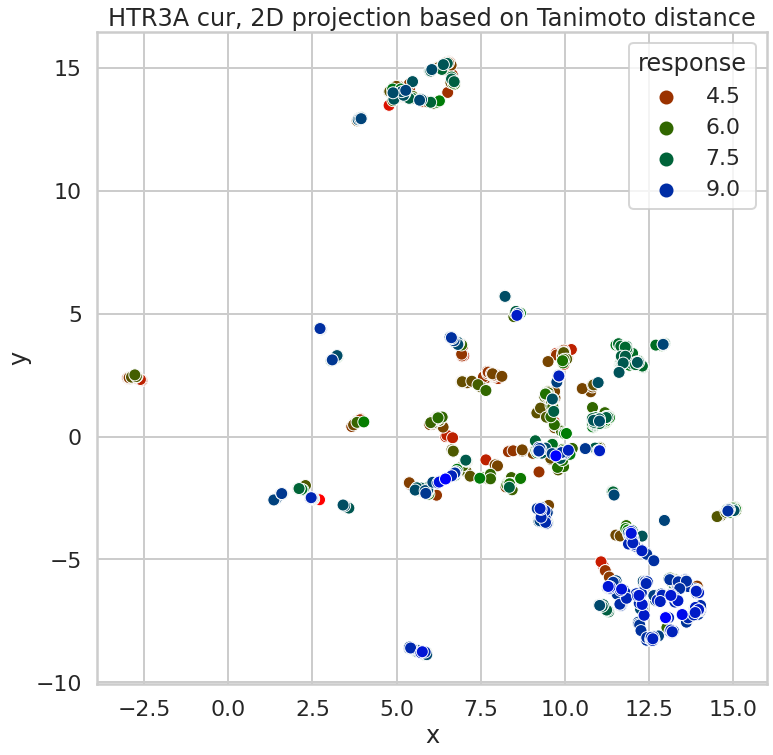

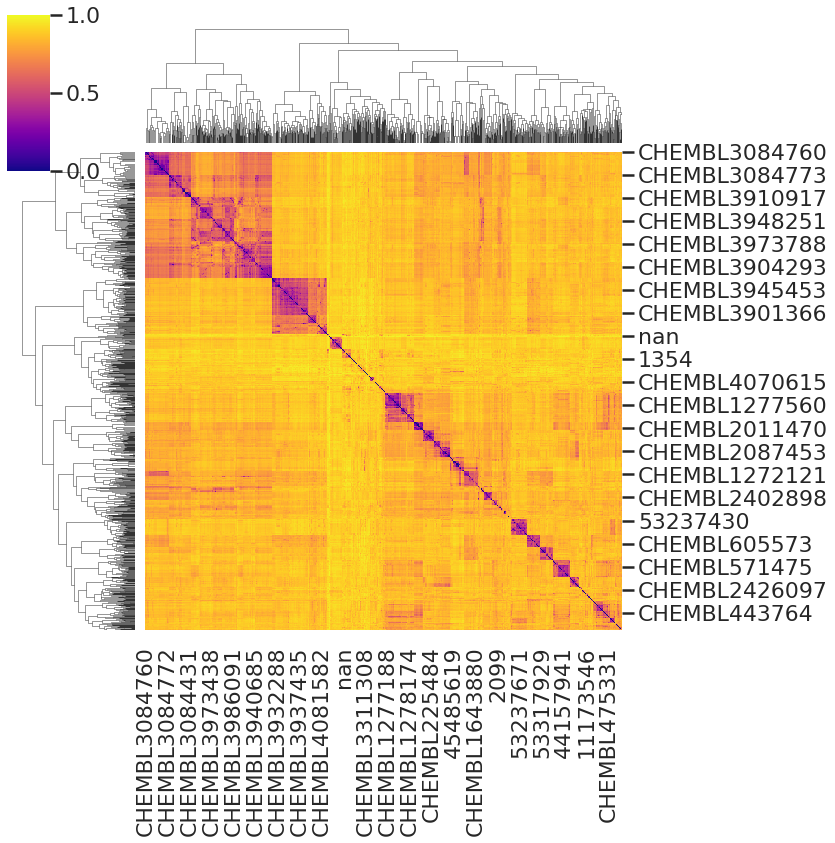

In [ ]:
dp.diversity_plots('/content/drive/MyDrive/Columbia_E4511/CYP3A4_cur.csv', 
                   datastore = False,
                   id_col ='compound_id', 
                   smiles_col = 'base_rdkit_smiles', 
                   is_base_smiles=True, 
                   response_col = 'pXC50',
                   ecfp_radius = 2)

Computing fingerprints...
Done
Computing Tanimoto distance matrix...
Done


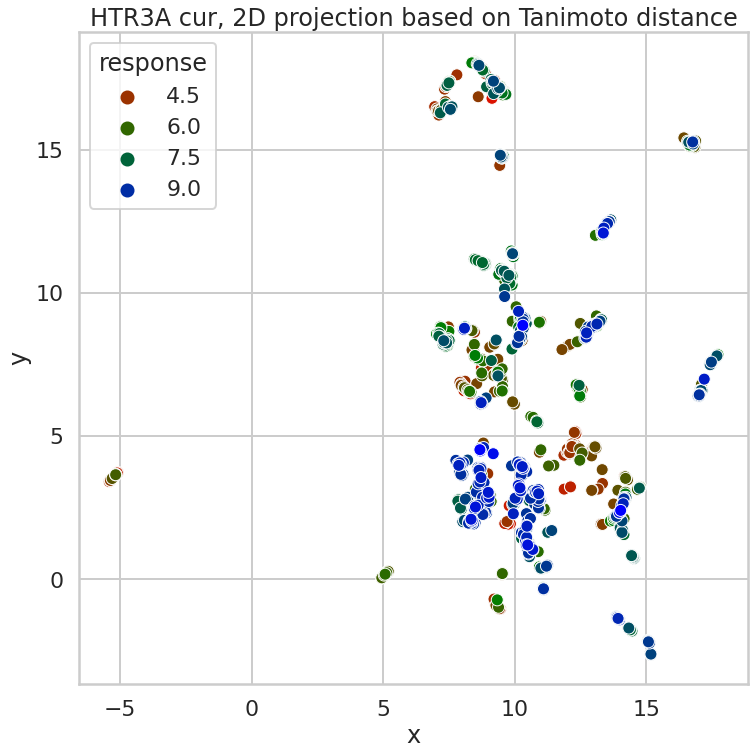

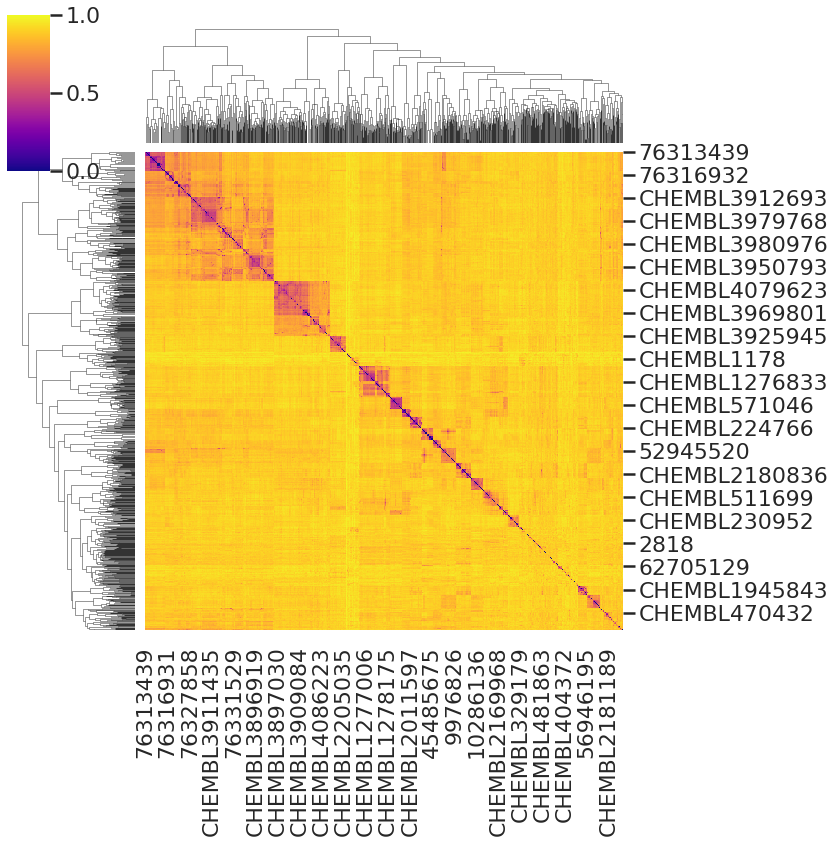

In [ ]:
dp.diversity_plots('/content/drive/MyDrive/Columbia_E4511/CYP3A4_cur.csv', 
                   datastore = False,
                   id_col ='compound_id', 
                   smiles_col = 'base_rdkit_smiles', 
                   is_base_smiles=True, 
                   response_col = 'pXC50',
                   ecfp_radius = 6)

The following code takes too long. Try only when you are running this
on a dedicated server

In [ ]:
# warning: 1000 doesn't work, takes too long
importlib.reload(dp)
# dp.diversity_plots('/content/drive/MyDrive/Columbia_E4511/HTR3A_cur.csv', 
#                    id_col ='compound_id', smiles_col = 'base_rdkit_smiles', 
#                    is_base_smiles=True, response_col = 'pXC50', 
#                    max_for_mcs=1100)

<module 'atomsci.ddm.pipeline.diversity_plots' from '/usr/local/lib/python3.7/site-packages/atomsci/ddm/pipeline/diversity_plots.py'>

# Now you're ready to move on to the next stage of EDA & modeling: featurizing datasets
- featurize with structure-based fingerprints like ECFP
- or molecular descriptor sets like RDKit and Mordred
- these are high - dimensional datasets (200-2000 features or 'dimensions')
- so UMAP, tSNE and other dimensionality reduction techniques will help visualize the 'chemical space' of the dataset